# Projeto de ETL 


Este projeto tem como objetivo a realização de um processo de ETL que consolide as bases disponibilizadas em somente uma base consolidada. Base de dados de Comunicação de Acidente de Trabalho (CAT) original pode ser encontrada em [dados.gov.br](https://dados.gov.br/dados/conjuntos-dados/inss-comunicacao-de-acidente-de-trabalho-cat1).

Significado de cada coluna do dataframe:
*   Agente  Causador  Acidente - Descrição do agente causador do acidente;
*   Data Acidente - Data do acidente de trabalho registrada na CAT;
*   CBO - Código Brasileiro de Ocupação;
*   CID-10 - Identificador da doença de cordo com o CID-10 - Código Internacional de Doenças;
*   CNAE2.0 Empregador - Classificação Nacional da Aividade Econômica no AEPS;
*   CNAE2.0 Empregador.1 - Descrição do CNAE;
*   Emitente CAT - Emitente da CAT;
*   Espécie do benefício - Espécie do benefício;
*   Filiação Segurado - Tipo de filiação à previdência social do segurado da CAT;
*   Indica Óbito Acidente - Indicador de óbito do segurado;
*   Munic Empr - Município e código do município do empregador;
*   Natureza da Lesão - Descrição da natureza da lesão do segurado;
*   Origem de Cadastramento CAT - Origem do cadastramento da CAT;
*   Parte Corpo Atingida - Parte do corpo atingida;
*   Sexo - Sexo do segurado informado na CAT;
*   Tipo do Acidente - Tipo do acidente de trabalho sofrido pelo segurado;
*   UF  Munic.  Acidente - Unidade da Federação do local do acidente;
*   UF Munic. Empregador - Unidade da Federação do município do empregador;
*   Data Acidente.1 - Data do acidente de trabalho registrada na CAT;
*   Data Despacho Benefício - Data do despacho do benefício;
*   Data Acidente.2 - Data do acidente de trabalho registrada na CAT;
*   Data Nascimento - Data do nascimento do segurado;
*   Data Emissão CAT - Data de emissão da CAT;
*   CNPJ/CEI Empregador - Cadastro Nacional de Pessoa Jurídica do empregador.

Responsáveis pelo projeto: [Giovana de Brito Silva](https://www.linkedin.com/in/giovanadebritosilva/) e [Wilbert Silva](https://www.linkedin.com/in/wilbertsilva/).

# Instalações

In [ ]:
!pip install pyspark
!pip install gcsfs
!pip install mysql-connector-python
!pip install PyMySQL

# Importações


In [ ]:
import pymongo 
import os
import pandas as pd
import numpy as np
import mysql.connector
import datetime

In [ ]:
from pymongo import MongoClient
from google.cloud import storage
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import NullType
from mysql.connector import Error
from sqlalchemy import create_engine

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# setando configurações de display do pandas
pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100000000)

# Enviar Dados ao MongoDB Atlas

## Conector 

In [ ]:
# conector do mongo atlas
uri = "mongodb+srv://giovana-soulcode.quvpom8.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri, tls=True, tlsCertificateKeyFile='/content/drive/MyDrive/X509-cert-7346878477947766211.pem')

## df1 (D.SDA.PDA.005.CAT.202201.csv)

In [ ]:
# abrindo df original com pandas 
df1 = pd.read_csv('/content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202201.csv', sep=';', encoding='ISO-8859-1')

In [ ]:
# foi análisado que há dados com { e ( abertas, mas que não foram fechadas
df1

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152135,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
152136,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
152137,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
152138,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


In [ ]:
# analisando se há dados nulos
df1.isna().sum()

Agente  Causador  Acidente     0
Data Acidente                  0
CBO                            0
CID-10                         0
CNAE2.0 Empregador             0
CNAE2.0 Empregador.1           0
Emitente CAT                   0
Espécie do benefício           0
Filiação Segurado              0
Indica Óbito Acidente          0
Munic Empr                     0
Natureza da Lesão              0
Origem de Cadastramento CAT    0
Parte Corpo Atingida           0
Sexo                           0
Tipo do Acidente               0
UF  Munic.  Acidente           0
UF Munic. Empregador           0
Data Acidente.1                0
Data Despacho Benefício        0
Data Acidente.2                0
Data Nascimento                0
Data Emissão CAT               0
CNPJ/CEI Empregador            0
dtype: int64

In [ ]:
df1.shape

(152140, 24)

In [ ]:
# decidimos dividir o dataset em datasets menores para evitar erros
df1_parte1 = df1.loc[0:40000]
df1_parte2 = df1.loc[40001:80000]
df1_parte3 = df1.loc[80001:120000]
df1_parte4 = df1.loc[120001:152140]

In [ ]:
# escolha/crie o database e colecao
db = client['CAT']
colecao1 = db['CAT_202201_orig']
# verificar conexão / Qtd. documentos da coleção
colecao1.count_documents({})

0

In [ ]:
# enviar o DF para colecao selecionada no mongo
df1_dict = df1_parte1.to_dict("records")
colecao1.insert_many(df1_dict)

In [ ]:
df1_dict = df1_parte2.to_dict("records")
colecao1.insert_many(df1_dict)

In [ ]:
df1_dict = df1_parte3.to_dict("records")
colecao1.insert_many(df1_dict)

In [ ]:
df1_dict = df1_parte4.to_dict("records")
colecao1.insert_many(df1_dict)

In [ ]:
colecao1.count_documents({})

152140

In [ ]:
# verificando se ocorreu tudo bem utilizando pandas
cursor = colecao1.find({})
df1_pd = pd.DataFrame(list(cursor))
df1_pd

,_id,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,639dd330f631ef4c96299fa0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,639dd330f631ef4c96299fa1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,639dd330f631ef4c96299fa2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,639dd330f631ef4c96299fa3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,639dd330f631ef4c96299fa4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152135,639dd360f631ef4c962bf1e7,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
152136,639dd360f631ef4c962bf1e8,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
152137,639dd360f631ef4c962bf1e9,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
152138,639dd360f631ef4c962bf1ea,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


## df2 (D.SDA.PDA.005.CAT.202204.csv)

In [ ]:
# abrindo df original com pandas 
df2 = pd.read_csv('/content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202204.csv', sep=';', encoding='ISO-8859-1')

In [ ]:
# foi análisado que há dados com { e ( abertas, mas que não foram fechadas
df2

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/05,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Lesao Imediata,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,13/11/1989,01/06/2022,57.571.275.002.570
1,Rua e Estrada - Superficie Utilizada para Sus,2022/05,992225-Auxiliar Geral de Conservação de Vias,S93.4 Entorse e Distensao do Tornozelo,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Luxacao,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,19/04/1990,01/06/2022,57.571.275.002.570
2,{ñ class},2022/05,{ñ class},B34.2 Infecc p/Coronavirus Ne,8513,Ensino Fundamental,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/05,0000/00,29/05/2022,13/09/1960,01/06/2022,47.715.347.000.184
3,"Revestimento Ceramico (Azulejo, Mosaico, Etc.",2022/05,783225-Ajudante de Motorista,S90.3 Contusao de Outr Partes e Partes Ne Do,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,350210-Andradina,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Pe (Exceto Artelhos),Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,31/05/2022,17/07/1994,01/06/2022,38.300.481.000.123
4,Calcada ou Caminho para Pedestre - Superficie,2022/05,322205-Tec. de Enfermagem,S51.0 Ferim do Cotovelo,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,350950-Campinas,"Escoriacao, Abrasao (Ferimento Superficial)",Internet,Cotovelo,Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,30/05/2022,30/01/1992,01/06/2022,46.020.301.000.269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89597,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
89598,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
89599,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
89600,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


In [ ]:
# analisando se há dados nulos
df2.isna().sum()

Agente  Causador  Acidente     0
Data Acidente                  0
CBO                            0
CID-10                         0
CNAE2.0 Empregador             0
CNAE2.0 Empregador.1           0
Emitente CAT                   0
Espécie do benefício           0
Filiação Segurado              0
Indica Óbito Acidente          0
Munic Empr                     0
Natureza da Lesão              0
Origem de Cadastramento CAT    0
Parte Corpo Atingida           0
Sexo                           0
Tipo do Acidente               0
UF  Munic.  Acidente           0
UF Munic. Empregador           0
Data Acidente.1                0
Data Despacho Benefício        0
Data Acidente.2                0
Data Nascimento                0
Data Emissão CAT               0
CNPJ/CEI Empregador            0
dtype: int64

In [ ]:
df2.shape

(89602, 24)

In [ ]:
# decidimos dividir o dataset em datasets menores para evitar erros
df2_parte1 = df2.loc[0:30000]
df2_parte2 = df2.loc[30001:60000]
df2_parte3 = df2.loc[60001:89602]

In [ ]:
# escolha/crie o database e colecao
db = client['CAT']
colecao2 = db['CAT_202204_orig']
# verificar conexão / Qtd. documentos da coleção
colecao2.count_documents({})

0

In [ ]:
# enviar o DF para colecao selecionada no mongo
df2_dict = df2_parte1.to_dict("records")
colecao2.insert_many(df2_dict)

In [ ]:
df2_dict = df2_parte2.to_dict("records")
colecao2.insert_many(df2_dict)

In [ ]:
df2_dict = df2_parte3.to_dict("records")
colecao2.insert_many(df2_dict)

In [ ]:
colecao2.count_documents({})

89602

In [ ]:
# verificando se ocorreu tudo bem utilizando pandas
cursor = colecao2.find({})
df2_pd = pd.DataFrame(list(cursor))
df2_pd

,_id,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,639dd38cf631ef4c962bf1ec,{ñ class},2022/05,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Lesao Imediata,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,13/11/1989,01/06/2022,57.571.275.002.570
1,639dd38cf631ef4c962bf1ed,Rua e Estrada - Superficie Utilizada para Sus,2022/05,992225-Auxiliar Geral de Conservação de Vias,S93.4 Entorse e Distensao do Tornozelo,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Luxacao,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,19/04/1990,01/06/2022,57.571.275.002.570
2,639dd38cf631ef4c962bf1ee,{ñ class},2022/05,{ñ class},B34.2 Infecc p/Coronavirus Ne,8513,Ensino Fundamental,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/05,0000/00,29/05/2022,13/09/1960,01/06/2022,47.715.347.000.184
3,639dd38cf631ef4c962bf1ef,"Revestimento Ceramico (Azulejo, Mosaico, Etc.",2022/05,783225-Ajudante de Motorista,S90.3 Contusao de Outr Partes e Partes Ne Do,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,350210-Andradina,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Pe (Exceto Artelhos),Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,31/05/2022,17/07/1994,01/06/2022,38.300.481.000.123
4,639dd38cf631ef4c962bf1f0,Calcada ou Caminho para Pedestre - Superficie,2022/05,322205-Tec. de Enfermagem,S51.0 Ferim do Cotovelo,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,350950-Campinas,"Escoriacao, Abrasao (Ferimento Superficial)",Internet,Cotovelo,Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,30/05/2022,30/01/1992,01/06/2022,46.020.301.000.269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89597,639dd3a9f631ef4c962d4fe9,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
89598,639dd3a9f631ef4c962d4fea,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
89599,639dd3a9f631ef4c962d4feb,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
89600,639dd3a9f631ef4c962d4fec,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


## df3 (D.SDA.PDA.005.CAT.202210.csv)

In [ ]:
# abrindo df original com pandas 
df3 = pd.read_csv('/content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202210.csv', sep=';', encoding='ISO-8859-1')

In [ ]:
df3

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,"Faca, Facao- Ferramenta Manual sem Forca Motr",2022/10,848515-Desossador,S51.0 Ferim do Cotovelo,1011,"Abate de Reses, Exceto Suinos",Empregador,Pa,Empregado,Não,521570-Palmeiras de Goiás,"Corte, Laceracao, Ferida Contusa, Punctura",Internet,Cotovelo,Masculino,Típico,{ñ class},Goiás,2022/10,0000/00,05/10/2022,05/11/1988,06/10/2022,00.000.000.000.000
1,"Aprision. Em, Sob ou Entre, Nic",2022/10,324115-Tec. em Radiologia e Imagenologia,S60.0 Contusao de Dedos s/Lesao da Unha,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,352590-Jundiaí,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/10,0000/00,04/10/2022,02/02/1989,06/10/2022,00.000.000.000.000
2,"Andaime, Plataforma - Edificio ou Estrutura",2022/10,715210-Pedreiro,S62.8 Frat de Outr Partes e de Partes Ne Punh,4120,Construcao de Edificios,Empregador,Pa,Empregado,Não,421370-Pouso Redondo,Fratura,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,{ñ class},Santa Catarina,2022/10,0000/00,05/10/2022,07/02/1981,06/10/2022,00.000.000.000.000
3,Veiculo Rodoviario Motorizado,2022/10,784205-Alimentador de Linha de Prod.,T02.2 Frat Envolv Regioes Mult de Um Membro S,4211,Construcao de Rodovias e Ferrovias,Empregador,Pa,Empregado,Sim,314480-Nova Lima,Lesoes Multiplas,Internet,Partes Multiplas - Aplica-Se Quando Mais de U,Masculino,Típico,Rondônia,Minas Gerais,2022/10,0000/00,05/10/2022,27/09/1958,06/10/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/10,717020-Servente de Obras,S62.5 Frat do Polegar,4110,Incorporacao de Empreendimentos Imobiliarios,Empregador,Pa,Empregado,Não,292740-Salvador,Fratura,Internet,Dedo,Masculino,Típico,{ñ class},Bahia,2022/10,0000/00,05/10/2022,09/08/1976,06/10/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15654,Piso de Edificio - Superficie Utilizada Para,2022/09,{ñ class},S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",{ñ class},Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
15655,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
15656,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
15657,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150


In [ ]:
# analisando se há dados nulos
df3.isna().sum()

Agente  Causador  Acidente     0
Data Acidente                  0
CBO                            0
CID-10                         0
CNAE2.0 Empregador             0
CNAE2.0 Empregador.1           0
Emitente CAT                   0
Espécie do benefício           0
Filiação Segurado              0
Indica Óbito Acidente          0
Munic Empr                     0
Natureza da Lesão              0
Origem de Cadastramento CAT    0
Parte Corpo Atingida           0
Sexo                           0
Tipo do Acidente               0
UF  Munic.  Acidente           0
UF Munic. Empregador           0
Data Acidente.1                0
Data Despacho Benefício        0
Data Acidente.2                0
Data Nascimento                0
Data Emissão CAT               0
CNPJ/CEI Empregador            0
dtype: int64

In [ ]:
# escolha/crie o database e colecao
db = client['CAT']
colecao3 = db['CAT_202210_orig']
# verificar conexão / Qtd. documentos da coleção
colecao3.count_documents({})

0

In [ ]:
# enviar o DF para colecao selecionada no mongo
df3_dict = df3.to_dict("records")
colecao3.insert_many(df3_dict)

In [ ]:
colecao3.count_documents({})

15659

In [ ]:
# verificando se ocorreu tudo bem utilizando pandas
cursor = colecao3.find({})
df3_pd = pd.DataFrame(list(cursor))
df3_pd

,_id,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,639dd3cbf631ef4c962d4fee,"Faca, Facao- Ferramenta Manual sem Forca Motr",2022/10,848515-Desossador,S51.0 Ferim do Cotovelo,1011,"Abate de Reses, Exceto Suinos",Empregador,Pa,Empregado,Não,521570-Palmeiras de Goiás,"Corte, Laceracao, Ferida Contusa, Punctura",Internet,Cotovelo,Masculino,Típico,{ñ class},Goiás,2022/10,0000/00,05/10/2022,05/11/1988,06/10/2022,00.000.000.000.000
1,639dd3cbf631ef4c962d4fef,"Aprision. Em, Sob ou Entre, Nic",2022/10,324115-Tec. em Radiologia e Imagenologia,S60.0 Contusao de Dedos s/Lesao da Unha,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,352590-Jundiaí,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/10,0000/00,04/10/2022,02/02/1989,06/10/2022,00.000.000.000.000
2,639dd3cbf631ef4c962d4ff0,"Andaime, Plataforma - Edificio ou Estrutura",2022/10,715210-Pedreiro,S62.8 Frat de Outr Partes e de Partes Ne Punh,4120,Construcao de Edificios,Empregador,Pa,Empregado,Não,421370-Pouso Redondo,Fratura,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,{ñ class},Santa Catarina,2022/10,0000/00,05/10/2022,07/02/1981,06/10/2022,00.000.000.000.000
3,639dd3cbf631ef4c962d4ff1,Veiculo Rodoviario Motorizado,2022/10,784205-Alimentador de Linha de Prod.,T02.2 Frat Envolv Regioes Mult de Um Membro S,4211,Construcao de Rodovias e Ferrovias,Empregador,Pa,Empregado,Sim,314480-Nova Lima,Lesoes Multiplas,Internet,Partes Multiplas - Aplica-Se Quando Mais de U,Masculino,Típico,Rondônia,Minas Gerais,2022/10,0000/00,05/10/2022,27/09/1958,06/10/2022,00.000.000.000.000
4,639dd3cbf631ef4c962d4ff2,Impacto de Pes. Contra Objeto em Movimento,2022/10,717020-Servente de Obras,S62.5 Frat do Polegar,4110,Incorporacao de Empreendimentos Imobiliarios,Empregador,Pa,Empregado,Não,292740-Salvador,Fratura,Internet,Dedo,Masculino,Típico,{ñ class},Bahia,2022/10,0000/00,05/10/2022,09/08/1976,06/10/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15654,639dd3cbf631ef4c962d8d14,Piso de Edificio - Superficie Utilizada Para,2022/09,{ñ class},S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",{ñ class},Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
15655,639dd3cbf631ef4c962d8d15,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
15656,639dd3cbf631ef4c962d8d16,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
15657,639dd3cbf631ef4c962d8d17,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/

# Enviar Dados ao CloudStorage

## Configuração GCS

In [ ]:
# configuração da chave de segurança
serviceAccount = '/content/drive/MyDrive/bc26-aulas-wilbert-14d4f74cd187.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

## Enviando DFs ao GCS

In [ ]:
# função para fazer upload de arquivo no bucket
def upload_blob(bucket, arquivo, destino):
    client = storage.Client()
    bucket = client.bucket(bucket)
    blob = bucket.blob(destino)

    blob.upload_from_filename(arquivo)

    print(
        f"Arquivo {arquivo} foi upado em {destino}."
    )

In [ ]:
# Upload do arquivo 1
bucket = 'bc26-projeto-aquecimento'
arquivo = '/content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202201.csv'
destino = 'original/D.SDA.PDA.005.CAT.202201.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202201.csv foi upado em original/D.SDA.PDA.005.CAT.202201.csv.


In [ ]:
# Upload do arquivo 2
bucket = 'bc26-projeto-aquecimento'
arquivo = '/content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202204.csv'
destino = 'original/D.SDA.PDA.005.CAT.202204.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202204.csv foi upado em original/D.SDA.PDA.005.CAT.202204.csv.


In [ ]:
# Upload do arquivo 3
bucket = 'bc26-projeto-aquecimento'
arquivo = '/content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202210.csv'
destino = 'original/D.SDA.PDA.005.CAT.202210.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/drive/MyDrive/Datasets/D.SDA.PDA.005.CAT.202210.csv foi upado em original/D.SDA.PDA.005.CAT.202210.csv.


In [ ]:
# caregando dfs pelo pandas para conferir se a transferência deu certo
df1 = pd.read_csv('gs://bc26-projeto-aquecimento/original/D.SDA.PDA.005.CAT.202201.csv', sep=';',encoding='ISO-8859-1')
df2 = pd.read_csv('gs://bc26-projeto-aquecimento/original/D.SDA.PDA.005.CAT.202204.csv', sep=';',encoding='ISO-8859-1')
df3 = pd.read_csv('gs://bc26-projeto-aquecimento/original/D.SDA.PDA.005.CAT.202210.csv', sep=';',encoding='ISO-8859-1')

In [ ]:
df1

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,355030-São Paulo,Fratura,Internet,Braco (Entre O Punho a O Ombro),Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,520110-Anápolis,Luxacao,Internet,Punho,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/01,{ñ class},S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,Empregador,Pa,Empregado,Não,330100-Campos dos Goytacazes,Luxacao,Internet,Perna (Entre O Tornozelo e a Pelvis),Masculino,Típico,Maranhão,São Paulo,2022/01,0000/00,28/01/2022,25/07/1995,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152135,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
152136,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
152137,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
152138,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


In [ ]:
df2

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/05,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Lesao Imediata,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,13/11/1989,01/06/2022,57.571.275.002.570
1,Rua e Estrada - Superficie Utilizada para Sus,2022/05,992225-Auxiliar Geral de Conservação de Vias,S93.4 Entorse e Distensao do Tornozelo,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Luxacao,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,26/05/2022,19/04/1990,01/06/2022,57.571.275.002.570
2,{ñ class},2022/05,{ñ class},B34.2 Infecc p/Coronavirus Ne,8513,Ensino Fundamental,Empregador,Pa,Empregado,Não,354780-Santo André-Sp,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,Aparelho Respiratorio,Feminino,Doença,Maranhão,São Paulo,2022/05,0000/00,29/05/2022,13/09/1960,01/06/2022,47.715.347.000.184
3,"Revestimento Ceramico (Azulejo, Mosaico, Etc.",2022/05,783225-Ajudante de Motorista,S90.3 Contusao de Outr Partes e Partes Ne Do,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,350210-Andradina,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Pe (Exceto Artelhos),Masculino,Típico,Maranhão,São Paulo,2022/05,0000/00,31/05/2022,17/07/1994,01/06/2022,38.300.481.000.123
4,Calcada ou Caminho para Pedestre - Superficie,2022/05,322205-Tec. de Enfermagem,S51.0 Ferim do Cotovelo,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,350950-Campinas,"Escoriacao, Abrasao (Ferimento Superficial)",Internet,Cotovelo,Feminino,Trajeto,Maranhão,São Paulo,2022/05,0000/00,30/05/2022,30/01/1992,01/06/2022,46.020.301.000.269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89597,{ñ class},2022/04,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,12/04/2022,08/11/1965,00/00/0000,00.000.000.000.000
89598,{ñ class},2022/04,000000-Não Informado,S82.1 Frat da Extremidade Proximal da Tibia,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/04,2022/06,30/04/2022,21/11/1985,00/00/0000,00.000.000.000.000
89599,{ñ class},2022/05,000000-Não Informado,S62.6 Frat de Outr Dedos,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,05/05/2022,27/01/1992,00/00/0000,00.000.000.000.000
89600,{ñ class},2022/05,000000-Não Informado,S82.6 Frat do Maleolo Lateral,0,{ñ class},{ñ class},Auxílio Doenca por Acidente do Trabalho,{ñ class},{ñ,000000-Ignorado,{ñ class},{ñ class,{ñ class},Masculino,Ignorado,Sergipe,Zerado,2022/05,2022/06,15/05/2022,14/01/1975,00/00/0000,00.000.000.000.000


In [ ]:
df3

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,Munic Empr,Natureza da Lesão,Origem de Cadastramento CAT,Parte Corpo Atingida,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,"Faca, Facao- Ferramenta Manual sem Forca Motr",2022/10,848515-Desossador,S51.0 Ferim do Cotovelo,1011,"Abate de Reses, Exceto Suinos",Empregador,Pa,Empregado,Não,521570-Palmeiras de Goiás,"Corte, Laceracao, Ferida Contusa, Punctura",Internet,Cotovelo,Masculino,Típico,{ñ class},Goiás,2022/10,0000/00,05/10/2022,05/11/1988,06/10/2022,00.000.000.000.000
1,"Aprision. Em, Sob ou Entre, Nic",2022/10,324115-Tec. em Radiologia e Imagenologia,S60.0 Contusao de Dedos s/Lesao da Unha,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,352590-Jundiaí,"Contusao, Esmagamento (Superficie Cutanea I",Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022/10,0000/00,04/10/2022,02/02/1989,06/10/2022,00.000.000.000.000
2,"Andaime, Plataforma - Edificio ou Estrutura",2022/10,715210-Pedreiro,S62.8 Frat de Outr Partes e de Partes Ne Punh,4120,Construcao de Edificios,Empregador,Pa,Empregado,Não,421370-Pouso Redondo,Fratura,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,{ñ class},Santa Catarina,2022/10,0000/00,05/10/2022,07/02/1981,06/10/2022,00.000.000.000.000
3,Veiculo Rodoviario Motorizado,2022/10,784205-Alimentador de Linha de Prod.,T02.2 Frat Envolv Regioes Mult de Um Membro S,4211,Construcao de Rodovias e Ferrovias,Empregador,Pa,Empregado,Sim,314480-Nova Lima,Lesoes Multiplas,Internet,Partes Multiplas - Aplica-Se Quando Mais de U,Masculino,Típico,Rondônia,Minas Gerais,2022/10,0000/00,05/10/2022,27/09/1958,06/10/2022,00.000.000.000.000
4,Impacto de Pes. Contra Objeto em Movimento,2022/10,717020-Servente de Obras,S62.5 Frat do Polegar,4110,Incorporacao de Empreendimentos Imobiliarios,Empregador,Pa,Empregado,Não,292740-Salvador,Fratura,Internet,Dedo,Masculino,Típico,{ñ class},Bahia,2022/10,0000/00,05/10/2022,09/08/1976,06/10/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15654,Piso de Edificio - Superficie Utilizada Para,2022/09,{ñ class},S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",{ñ class},Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410960-Guaratuba,Lesao Imediata,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Roraima,Paraná,2022/09,2022/10,29/09/2022,18/09/1993,10/10/2022,21.161.901.000.135
15655,Escada Permanente Cujos Degraus Permitem Apoi,2022/10,232130-Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,Autoridade Pública,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,410690-Curitiba,Fratura,Internet,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",Feminino,Típico,Roraima,Paraná,2022/10,2022/11,06/10/2022,24/11/1986,07/10/2022,76.416.965.000.121
15656,"Andaime, Plataforma - Edificio ou Estrutura",2022/09,517330-Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,Segurado/Dependente,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,420460-Criciúma,Fratura,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Típico,{ñ class},Santa Catarina,2022/09,2022/10,20/09/2022,02/03/1986,10/10/2022,32.994.401.000.109
15657,"Martelo, Malho, Marreta- Ferramenta Manual Se",2022/10,724315-Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,Empregador,Auxílio Doenca por Acidente do Trabalho,Empregado,Não,411000-Iguaraçu,Fratura,Internet,Dedo,Masculino,Típico,Roraima,Paraná,2022/10,2022/10,05/10/2022,08/04/1984,06/10/2022,34.197.591.000.150


# Trabalhando com PySpark

## SparkSession

In [ ]:
#criando a spark session com o config de conector da gcs
spark = (
    SparkSession.builder
                .master('local')
                .appName('ProjAq')
                .config('spark.ui.port', '4050')
                .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                .getOrCreate()
)

In [ ]:
spark

## Criando Schema

In [ ]:
# criando esquema de dados para determinar seus tipos
esquema = (
    StructType([
        StructField('Agente  Causador  Acidente', StringType()),
        StructField('Data Acidente1', StringType()),
        StructField('CBO', StringType()),
        StructField('CID-10', StringType()),
        StructField('CNAE2.0 Empregador4', IntegerType()),
        StructField('CNAE2.0 Empregador5', StringType()),
        StructField('Emitente CAT', StringType()),
        StructField('Espécie do benefício', StringType()),
        StructField('Filiação Segurado', StringType()),
        StructField('Indica Óbito Acidente', StringType()),
        StructField('Munic Empr', StringType()),
        StructField('Natureza da Lesão', StringType()),
        StructField('Origem de Cadastramento CAT', StringType()),
        StructField('Parte Corpo Atingida', StringType()),
        StructField('Sexo', StringType()),
        StructField('Tipo do Acidente', StringType()),
        StructField('UF  Munic.  Acidente', StringType()),
        StructField('UF Munic. Empregador', StringType()),
        StructField('Data Acidente18', StringType()),
        StructField('Data Despacho Benefício', StringType()),
        StructField('Data Acidente20', StringType()),
        StructField('Data Nascimento', StringType()),
        StructField('Data Emissão CAT', StringType()),
        StructField('CNPJ/CEI Empregador', StringType())
    ])
)

## Configurando DFs

In [ ]:
# fazer acesso a bucket
client = storage.Client()

# criar uma variável
bucket = client.get_bucket('bc26-projeto-aquecimento')

# escolher arquivo dentro da bucket
bucket.blob('/original/D.SDA.PDA.005.CAT.202201.csv')

# criar uma variável para receber o caminho do arquivo
path1 = 'gs://bc26-projeto-aquecimento/original/D.SDA.PDA.005.CAT.202201.csv'

In [ ]:
df1 = (
    spark.read.format('csv')
              .option('header', 'true')
              .option('inferschema', 'false')
              .option('delimiter', ';')
              .option("encoding", "ISO-8859-1")
              .load(path1, schema = esquema)
)

In [ ]:
df1.printSchema()

root
 |-- Agente  Causador  Acidente: string (nullable = true)
 |-- Data Acidente1: string (nullable = true)
 |-- CBO: string (nullable = true)
 |-- CID-10: string (nullable = true)
 |-- CNAE2.0 Empregador4: integer (nullable = true)
 |-- CNAE2.0 Empregador5: string (nullable = true)
 |-- Emitente CAT: string (nullable = true)
 |-- Espécie do benefício: string (nullable = true)
 |-- Filiação Segurado: string (nullable = true)
 |-- Indica Óbito Acidente: string (nullable = true)
 |-- Munic Empr: string (nullable = true)
 |-- Natureza da Lesão: string (nullable = true)
 |-- Origem de Cadastramento CAT: string (nullable = true)
 |-- Parte Corpo Atingida: string (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Tipo do Acidente: string (nullable = true)
 |-- UF  Munic.  Acidente: string (nullable = true)
 |-- UF Munic. Empregador: string (nullable = true)
 |-- Data Acidente18: string (nullable = true)
 |-- Data Despacho Benefício: string (nullable = true)
 |-- Data Acidente20: str

In [ ]:
df1.show(truncate=False)

+---------------------------------------------+--------------+---------------------------------------------+---------------------------------------------+-------------------+---------------------------------------------+-------------------+---------------------------------------------+---------------------------------------------+---------------------+-----------------------------------------+---------------------------------------------+---------------------------+---------------------------------------------+-------------+----------------+--------------------+--------------------+---------------+-----------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente                   |Data Acidente1|CBO                                          |CID-10                                       |CNAE2.0 Empregador4|CNAE2.0 Empregador5                          |Emitente CAT       |Espécie do benefício                         |Filiação Segura

In [ ]:
# fazer acesso a bucket
client = storage.Client()

# criar uma variável
bucket = client.get_bucket('bc26-projeto-aquecimento')

# escolher arquivo dentro da bucket
bucket.blob('/original/D.SDA.PDA.005.CAT.202204.csv')

# criar uma variável para receber o caminho do arquivo
path2 = 'gs://bc26-projeto-aquecimento/original/D.SDA.PDA.005.CAT.202204.csv'

In [ ]:
df2 = (
    spark.read.format('csv')
              .option('header', 'true')
              .option('inferschema', 'false')
              .option('delimiter', ';')
              .option("encoding", "ISO-8859-1")
              .load(path2, schema = esquema)
)

In [ ]:
df2.printSchema()

root
 |-- Agente  Causador  Acidente: string (nullable = true)
 |-- Data Acidente1: string (nullable = true)
 |-- CBO: string (nullable = true)
 |-- CID-10: string (nullable = true)
 |-- CNAE2.0 Empregador4: integer (nullable = true)
 |-- CNAE2.0 Empregador5: string (nullable = true)
 |-- Emitente CAT: string (nullable = true)
 |-- Espécie do benefício: string (nullable = true)
 |-- Filiação Segurado: string (nullable = true)
 |-- Indica Óbito Acidente: string (nullable = true)
 |-- Munic Empr: string (nullable = true)
 |-- Natureza da Lesão: string (nullable = true)
 |-- Origem de Cadastramento CAT: string (nullable = true)
 |-- Parte Corpo Atingida: string (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Tipo do Acidente: string (nullable = true)
 |-- UF  Munic.  Acidente: string (nullable = true)
 |-- UF Munic. Empregador: string (nullable = true)
 |-- Data Acidente18: string (nullable = true)
 |-- Data Despacho Benefício: string (nullable = true)
 |-- Data Acidente20: str

In [ ]:
df2.show(truncate=False)

+---------------------------------------------+--------------+---------------------------------------------+---------------------------------------------+-------------------+---------------------------------------------+-------------------+---------------------------------------------+---------------------------------------------+---------------------+-----------------------------------------+---------------------------------------------+---------------------------+---------------------------------------------+-------------+----------------+--------------------+--------------------+---------------+-----------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente                   |Data Acidente1|CBO                                          |CID-10                                       |CNAE2.0 Empregador4|CNAE2.0 Empregador5                          |Emitente CAT       |Espécie do benefício                         |Filiação Segura

In [ ]:
# fazer acesso a bucket
client = storage.Client()

# criar uma variável
bucket = client.get_bucket('bc26-projeto-aquecimento')

# escolher arquivo dentro da bucket
bucket.blob('/original/D.SDA.PDA.005.CAT.202210.csv')

# criar uma variável para receber o caminho do arquivo
path3 = 'gs://bc26-projeto-aquecimento/original/D.SDA.PDA.005.CAT.202210.csv'

In [ ]:
df3 = (
    spark.read.format('csv')
              .option('header', 'true')
              .option('inferschema', 'false')
              .option('delimiter', ';')
              .option("encoding", "ISO-8859-1")
              .load(path3, schema = esquema)
)

In [ ]:
df3.printSchema()

root
 |-- Agente  Causador  Acidente: string (nullable = true)
 |-- Data Acidente1: string (nullable = true)
 |-- CBO: string (nullable = true)
 |-- CID-10: string (nullable = true)
 |-- CNAE2.0 Empregador4: integer (nullable = true)
 |-- CNAE2.0 Empregador5: string (nullable = true)
 |-- Emitente CAT: string (nullable = true)
 |-- Espécie do benefício: string (nullable = true)
 |-- Filiação Segurado: string (nullable = true)
 |-- Indica Óbito Acidente: string (nullable = true)
 |-- Munic Empr: string (nullable = true)
 |-- Natureza da Lesão: string (nullable = true)
 |-- Origem de Cadastramento CAT: string (nullable = true)
 |-- Parte Corpo Atingida: string (nullable = true)
 |-- Sexo: string (nullable = true)
 |-- Tipo do Acidente: string (nullable = true)
 |-- UF  Munic.  Acidente: string (nullable = true)
 |-- UF Munic. Empregador: string (nullable = true)
 |-- Data Acidente18: string (nullable = true)
 |-- Data Despacho Benefício: string (nullable = true)
 |-- Data Acidente20: str

In [ ]:
df3.show(truncate=False)

+---------------------------------------------+--------------+---------------------------------------------+---------------------------------------------+-------------------+---------------------------------------------+-------------------+---------------------------------------------+---------------------------------------------+---------------------+-----------------------------------------+---------------------------------------------+---------------------------+---------------------------------------------+-------------+----------------+--------------------+--------------------+---------------+-----------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente                   |Data Acidente1|CBO                                          |CID-10                                       |CNAE2.0 Empregador4|CNAE2.0 Empregador5                          |Emitente CAT       |Espécie do benefício                         |Filiação Segura

## Concatenando DFs

In [ ]:
# pelo pandas, a forma de unificar as colunas seria pelo df = pd.concat([df1, df2], ignore_index=True) e após df = pd.concat([df, df3], ignore_index=True) 
# porém analisamos que seria melhor iniciar a análise pelo PySpark, então fizemos a união das planilhas por ele utilizando union

In [ ]:
# decidimos concatenar todos os DFs para facilitar a análise
df = df1.union(df2)

In [ ]:
df.count()

241742

In [ ]:
df = df.union(df3)

In [ ]:
df.count()

257401

## Drops

### Linhas Duplicadas

In [ ]:
# contando quantas linha duplicadas existem no df
total_linhas = df.count()
total_linhas_distintas = df.distinct().count()

print('O total de linhas duplicadas é de: ', total_linhas - total_linhas_distintas)

O total de linhas duplicadas é de:  100652


In [ ]:
# dropando linhas duplicadas no dataframe
df = df.dropDuplicates()
df = df.distinct()

total_linhas = df.count()
total_linhas_distintas = df.distinct().count()

print('O total de linhas duplicadas após o drop é de: ',total_linhas - total_linhas_distintas)

O total de linhas duplicadas após o drop é de:  0


### Colunas

In [ ]:
df.orderBy(F.col('Agente  Causador  Acidente').asc()).show()

+--------------------------+--------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------------+--------------------+-------------+----------------+--------------------+--------------------+---------------+-----------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente|Data Acidente1|                 CBO|              CID-10|CNAE2.0 Empregador4| CNAE2.0 Empregador5|       Emitente CAT|Espécie do benefício|   Filiação Segurado|Indica Óbito Acidente|          Munic Empr|   Natureza da Lesão|Origem de Cadastramento CAT|Parte Corpo Atingida|         Sexo|Tipo do Acidente|UF  Munic.  Acidente|UF Munic. Empregador|Data Acidente18|Data Despacho Benefício|Data Acidente20|Data Nascimento|Data Emissão CAT|CNPJ/CEI Empregador|
+--------------------------+----

In [ ]:
df.orderBy(F.col('Agente  Causador  Acidente').desc()).show()

+--------------------------+--------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------------+--------------------+-------------+----------------+--------------------+--------------------+---------------+-----------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente|Data Acidente1|                 CBO|              CID-10|CNAE2.0 Empregador4| CNAE2.0 Empregador5|       Emitente CAT|Espécie do benefício|   Filiação Segurado|Indica Óbito Acidente|          Munic Empr|   Natureza da Lesão|Origem de Cadastramento CAT|Parte Corpo Atingida|         Sexo|Tipo do Acidente|UF  Munic.  Acidente|UF Munic. Empregador|Data Acidente18|Data Despacho Benefício|Data Acidente20|Data Nascimento|Data Emissão CAT|CNPJ/CEI Empregador|
+--------------------------+----

In [ ]:
df.groupBy('Data Despacho Benefício').count().show()

+-----------------------+------+
|Data Despacho Benefício| count|
+-----------------------+------+
|                2022/03|  8320|
|                2022/07|  1201|
|                2022/01|   406|
|                2022/02|  3593|
|                0000/00|116777|
|                2022/06| 12439|
|                2022/04|  4974|
|                2022/10|     7|
|                2022/11|     2|
|                2022/05|  9030|
+-----------------------+------+



In [ ]:
# decidimos dar drop nas colunas Data Acidente1 e Data Acidente18, pois há data completa na coluna Data Acidente20
# decidimos das drop na coluna Data Despacho Benefício, pois mais da metade dos seus dados estão zerados e a data não está completa 
df1 = df.drop(F.col('Data Acidente1'))
df1 = df1.drop(F.col('Data Acidente18'))
df1 = df1.drop(F.col('Data Despacho Benefício'))
df1.show(5, truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+-------------------+---------------------------------------------+-------------------+---------------------------------------------+---------------------------------------------+---------------------+-----------------------------------------+---------------------------------------------+---------------------------+---------------------------------------------+-------------+----------------+--------------------+--------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente                   |CBO                                          |CID-10                                       |CNAE2.0 Empregador4|CNAE2.0 Empregador5                          |Emitente CAT       |Espécie do benefício                         |Filiação Segurado                            |Indica Óbito Acidente|Munic Empr       

### Mudando tipo de dado das colunas

In [ ]:
# converter data do formato string para o formado date - yyyy-MM-dd
df2 = df1.withColumn('Data Acidente20', F.to_date(F.col('Data Acidente20'), 'dd/MM/yyyy'))
df2 = df2.withColumn('Data Nascimento', F.to_date(F.col('Data Nascimento'), 'dd/MM/yyyy'))
df2 = df2.withColumn('Data Emissão CAT', F.to_date(F.col('Data Emissão CAT'), 'dd/MM/yyyy'))

df2.show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+-------------------+---------------------------------------------+-------------------+---------------------------------------------+---------------------------------------------+---------------------+-----------------------------------------+---------------------------------------------+---------------------------+---------------------------------------------+-------------+----------------+--------------------+--------------------+---------------+---------------+----------------+-------------------+
|Agente  Causador  Acidente                   |CBO                                          |CID-10                                       |CNAE2.0 Empregador4|CNAE2.0 Empregador5                          |Emitente CAT       |Espécie do benefício                         |Filiação Segurado                            |Indica Óbito Acidente|Munic Empr       

## Renomeando as colunas

In [ ]:
# renomeando colunas
df2 = ( df2.withColumnRenamed('Agente  Causador  Acidente', 'agente_causador')
         .withColumnRenamed('CBO', 'cbo')
         .withColumnRenamed('CID-10', 'cid_10')
         .withColumnRenamed('CNAE2.0 Empregador4', 'cnae_empredagor_codigo')
         .withColumnRenamed('CNAE2.0 Empregador5', 'cnae_empregador_descricao')
         .withColumnRenamed('Emitente CAT', 'emitente_cat')
         .withColumnRenamed('Espécie do benefício', 'especie_beneficio')
         .withColumnRenamed('Filiação Segurado', 'filiacao_segurado')
         .withColumnRenamed('Indica Óbito Acidente', 'indica_obito_acidente')
         .withColumnRenamed('Munic Empr', 'municipio_empregador')
         .withColumnRenamed('Natureza da Lesão', 'natureza_lesao')
         .withColumnRenamed('Origem de Cadastramento CAT', 'origem_cadastro')
         .withColumnRenamed('Parte Corpo Atingida', 'parte_corpo_atingida')
         .withColumnRenamed('Sexo', 'sexo')
         .withColumnRenamed('Tipo do Acidente', 'tipo_acidente')
         .withColumnRenamed('UF  Munic.  Acidente', 'uf_acidente')
         .withColumnRenamed('UF Munic. Empregador', 'uf_empregador')
         .withColumnRenamed('Data Acidente20', 'data_acidente')
         .withColumnRenamed('Data Nascimento', 'data_nascimento')
         .withColumnRenamed('Data Emissão CAT', 'data_emissao_cat')
         .withColumnRenamed('CNPJ/CEI Empregador', 'cnpj_empregador')
)

In [ ]:
df2.printSchema()

root
 |-- agente_causador: string (nullable = true)
 |-- cbo: string (nullable = true)
 |-- cid_10: string (nullable = true)
 |-- cnae_empredagor_codigo: integer (nullable = true)
 |-- cnae_empregador_descricao: string (nullable = true)
 |-- emitente_cat: string (nullable = true)
 |-- especie_beneficio: string (nullable = true)
 |-- filiacao_segurado: string (nullable = true)
 |-- indica_obito_acidente: string (nullable = true)
 |-- municipio_empregador: string (nullable = true)
 |-- natureza_lesao: string (nullable = true)
 |-- origem_cadastro: string (nullable = true)
 |-- parte_corpo_atingida: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- tipo_acidente: string (nullable = true)
 |-- uf_acidente: string (nullable = true)
 |-- uf_empregador: string (nullable = true)
 |-- data_acidente: date (nullable = true)
 |-- data_nascimento: date (nullable = true)
 |-- data_emissao_cat: date (nullable = true)
 |-- cnpj_empregador: string (nullable = true)



## Separando dados da coluna municipio_empregador

In [ ]:
# decidimos tirar o código que está junto com os municipíos, pois ele não irá influenciar na nossa análise
df3 = ( df2.withColumn('codigo_uf', F.substring(F.col('municipio_empregador'),1,6))
           .withColumn('municipio_empregador', F.substring(F.col('municipio_empregador'),8,50))
)

In [ ]:
df3.show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------------------+---------------------------------------------+-------------------+---------------------------------------------+---------------------------------------------+---------------------+----------------------------------+---------------------------------------------+---------------+---------------------------------------------+-------------+-------------+----------------+-------------------+-------------+---------------+----------------+------------------+---------+
|agente_causador                              |cbo                                          |cid_10                                       |cnae_empredagor_codigo|cnae_empregador_descricao                    |emitente_cat       |especie_beneficio                            |filiacao_segurado                            |indica_obito_acidente|municipio_empregador           

In [ ]:
df3.select(F.col('municipio_empregador')).orderBy(F.col('municipio_empregador').asc()).show()

+--------------------+
|municipio_empregador|
+--------------------+
|Abadia de Goiás  ...|
|Abadia de Goiás  ...|
|Abadia de Goiás  ...|
|Abadia de Goiás  ...|
|Abadia dos Dourad...|
|Abadiânia        ...|
|Abadiânia        ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
|Abaetetuba       ...|
+--------------------+
only showing top 20 rows



In [ ]:
df3.select(F.col('municipio_empregador')).orderBy(F.col('municipio_empregador').desc()).show(50, truncate=False)

+----------------------------------+
|municipio_empregador              |
+----------------------------------+
|Óleo                              |
|Óbidos                            |
|Óbidos                            |
|Óbidos                            |
|Óbidos                            |
|Óbidos                            |
|Óbidos                            |
|Óbidos                            |
|Álvares Machado                   |
|Álvares Machado                   |
|Álvares Machado                   |
|Álvares Florence                  |
|Álvares Florence                  |
|Águia Branca                      |
|Águia Branca                      |
|Águas de São Pedro                |
|Águas de São Pedro                |
|Águas de São Pedro                |
|Águas de Lindóia                  |
|Águas de Lindóia                  |
|Águas de Lindóia                  |
|Águas de Lindóia                  |
|Águas de Lindóia                  |
|Águas de Lindóia                  |
|

## Tirando espaços de dentro dos dados

In [ ]:
# analisamos que tem muitos espaços dentro dos dados, dificultando as análises, 
# então resolvemos tirá-los por meio do trim que tira apenas os espaços do início e fim da string
df4 = df3.select([F.trim(F.col(c)).alias(c) for c in df3.columns])
df4.show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------------------+---------------------------------------------+------------+-----------------+-----------------+---------------------+-----------------------+-------------------------------------------+---------------+---------------------------------------------+---------+-------------+-----------+-------------+-------------+---------------+----------------+------------------+---------+
|agente_causador                              |cbo                                          |cid_10                                       |cnae_empredagor_codigo|cnae_empregador_descricao                    |emitente_cat|especie_beneficio|filiacao_segurado|indica_obito_acidente|municipio_empregador   |natureza_lesao                             |origem_cadastro|parte_corpo_atingida                         |sexo     |tipo_acidente|uf_acidente|uf_empregador|data_

## Criação de novas colunas

In [ ]:
# criando coluna com a diferença dos dias entre o acidente e a emissão da cat
df5 = df4.withColumn('dif_dias_acidente_emissao', F.datediff(F.col('data_emissao_cat'), F.col('data_acidente')))

df5.select(F.col('data_acidente'), F.col('data_emissao_cat'), F.col('dif_dias_acidente_emissao')).show(truncate=False)

+-------------+----------------+-------------------------+
|data_acidente|data_emissao_cat|dif_dias_acidente_emissao|
+-------------+----------------+-------------------------+
|2022-01-21   |2022-03-01      |39                       |
|2022-02-28   |2022-03-01      |1                        |
|2022-02-04   |2022-03-01      |25                       |
|2022-02-22   |2022-03-02      |8                        |
|2022-02-27   |2022-03-02      |3                        |
|2022-03-01   |2022-03-02      |1                        |
|2022-02-25   |2022-03-02      |5                        |
|2022-02-04   |2022-03-02      |26                       |
|2022-02-23   |2022-03-02      |7                        |
|2022-02-24   |2022-03-03      |7                        |
|2022-02-26   |2022-03-03      |5                        |
|2022-01-31   |2022-03-03      |31                       |
|2022-03-02   |2022-03-03      |1                        |
|2022-03-02   |2022-03-03      |1                       

In [ ]:
# criando coluna juntando os dados de cidade e estado
df6 = df5.withColumn('cidade_estado_empregador', F.concat(F.col('municipio_empregador'),F.lit('-'), F.col('uf_empregador')))
df6.show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------------------+---------------------------------------------+------------+-----------------+-----------------+---------------------+-----------------------+-------------------------------------------+---------------+---------------------------------------------+---------+-------------+-----------+-------------+-------------+---------------+----------------+------------------+---------+-------------------------+----------------------------------+
|agente_causador                              |cbo                                          |cid_10                                       |cnae_empredagor_codigo|cnae_empregador_descricao                    |emitente_cat|especie_beneficio|filiacao_segurado|indica_obito_acidente|municipio_empregador   |natureza_lesao                             |origem_cadastro|parte_corpo_atingida                    

In [ ]:
# criando coluna com o dia atual
df7 = df6.withColumn('dia_hoje', F.lit('Nova Coluna Criada'))
df7 = df7.withColumn('dia_hoje', F.current_date())
df7.show()

+--------------------+--------------------+--------------------+----------------------+-------------------------+------------+-----------------+-----------------+---------------------+--------------------+--------------------+---------------+--------------------+---------+-------------+-----------+-------------+-------------+---------------+----------------+------------------+---------+-------------------------+------------------------+----------+
|     agente_causador|                 cbo|              cid_10|cnae_empredagor_codigo|cnae_empregador_descricao|emitente_cat|especie_beneficio|filiacao_segurado|indica_obito_acidente|municipio_empregador|      natureza_lesao|origem_cadastro|parte_corpo_atingida|     sexo|tipo_acidente|uf_acidente|uf_empregador|data_acidente|data_nascimento|data_emissao_cat|   cnpj_empregador|codigo_uf|dif_dias_acidente_emissao|cidade_estado_empregador|  dia_hoje|
+--------------------+--------------------+--------------------+----------------------+---------

In [ ]:
# criando coluna com a diferença dos dias entre o acidente e a emissão da cat
df7 = df7.withColumn('idade', F.months_between(F.col('dia_hoje'), F.col('data_nascimento')))
df7 = df7.withColumn('idade', F.round(F.col('idade')/12))

df7.select(F.col('data_nascimento'), F.col('dia_hoje'), F.col('idade')).show(truncate=False)

+---------------+----------+-----+
|data_nascimento|dia_hoje  |idade|
+---------------+----------+-----+
|1993-10-03     |2022-12-17|29.0 |
|1978-04-29     |2022-12-17|45.0 |
|1977-10-10     |2022-12-17|45.0 |
|1963-07-31     |2022-12-17|59.0 |
|2000-06-09     |2022-12-17|23.0 |
|1985-11-29     |2022-12-17|37.0 |
|1992-06-16     |2022-12-17|31.0 |
|1974-03-26     |2022-12-17|49.0 |
|1955-11-14     |2022-12-17|67.0 |
|1966-06-10     |2022-12-17|57.0 |
|1985-08-06     |2022-12-17|37.0 |
|1980-04-25     |2022-12-17|43.0 |
|1990-01-23     |2022-12-17|33.0 |
|1996-12-15     |2022-12-17|26.0 |
|2002-01-21     |2022-12-17|21.0 |
|1969-12-24     |2022-12-17|53.0 |
|1990-04-14     |2022-12-17|33.0 |
|1990-01-17     |2022-12-17|33.0 |
|1998-10-09     |2022-12-17|24.0 |
|1983-08-15     |2022-12-17|39.0 |
+---------------+----------+-----+
only showing top 20 rows



# Trabalhando com Pandas

## Transformando de PySpark para Pandas

In [ ]:
# converter para um df do pandas
df = df7.toPandas()

In [ ]:
# backup do dataframe original
dfback = df.copy() # sem o copy(), ele apenas faz um apontamento e o que alterar em um altera 

## Mudando tipo de colunas

In [ ]:
# analisamos que tem colunas com tipos diferentes do que eram para estar
df.dtypes

agente_causador               object
cbo                           object
cid_10                        object
cnae_empredagor_codigo        object
cnae_empregador_descricao     object
emitente_cat                  object
especie_beneficio             object
filiacao_segurado             object
indica_obito_acidente         object
municipio_empregador          object
natureza_lesao                object
origem_cadastro               object
parte_corpo_atingida          object
sexo                          object
tipo_acidente                 object
uf_acidente                   object
uf_empregador                 object
data_acidente                 object
data_nascimento               object
data_emissao_cat              object
cnpj_empregador               object
codigo_uf                     object
dif_dias_acidente_emissao    float64
cidade_estado_empregador      object
dia_hoje                      object
idade                        float64
dtype: object

In [ ]:
# alterado os tipos das colunas para os tipos certos (não irei mudar a dia_hoje, pois droparei essa coluna por não fazer importancia na nossa analise)
df["data_acidente"] = pd.to_datetime(df["data_acidente"], errors="coerce")

In [ ]:
df["data_nascimento"] = pd.to_datetime(df["data_nascimento"], errors="coerce")

In [ ]:
df["data_emissao_cat"] = pd.to_datetime(df["data_emissao_cat"], errors="coerce")

In [ ]:
df.dtypes

agente_causador                      object
cbo                                  object
cid_10                               object
cnae_empredagor_codigo               object
cnae_empregador_descricao            object
emitente_cat                         object
especie_beneficio                    object
filiacao_segurado                    object
indica_obito_acidente                object
municipio_empregador                 object
natureza_lesao                       object
origem_cadastro                      object
parte_corpo_atingida                 object
sexo                                 object
tipo_acidente                        object
uf_acidente                          object
uf_empregador                        object
data_acidente                datetime64[ns]
data_nascimento              datetime64[ns]
data_emissao_cat             datetime64[ns]
cnpj_empregador                      object
codigo_uf                            object
dif_dias_acidente_emissao       

In [ ]:
df

,agente_causador,cbo,cid_10,cnae_empredagor_codigo,cnae_empregador_descricao,emitente_cat,especie_beneficio,filiacao_segurado,indica_obito_acidente,municipio_empregador,natureza_lesao,origem_cadastro,parte_corpo_atingida,sexo,tipo_acidente,uf_acidente,uf_empregador,data_acidente,data_nascimento,data_emissao_cat,cnpj_empregador,codigo_uf,dif_dias_acidente_emissao,cidade_estado_empregador,dia_hoje,idade
0,{ñ class},322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,Macapá,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,"Sistemas e Aparelhos, Nic",Masculino,Doença,Paraíba,Amapá,2022-01-21,1993-10-03,2022-03-01,00.000.000.000.000,160030,39.0,Macapá-Amapá,2022-12-17,29.0
1,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,4754,"Comercio Varejista Especializado de Moveis, C",Empregador,Pa,Empregado,Não,Sorocaba,Fratura,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022-02-28,1978-04-29,2022-03-01,00.000.000.000.000,355220,1.0,Sorocaba-São Paulo,2022-12-17,45.0
2,Reacao do Corpo a Movimento Voluntario,723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Empregador,Pa,Empregado,Não,Araraquara,"Outras Lesoes, Nic",Internet,"Tronco, Nic",Masculino,Típico,Maranhão,São Paulo,2022-02-04,1977-10-10,2022-03-01,00.000.000.000.000,350320,25.0,Araraquara-São Paulo,2022-12-17,45.0
3,Veiculo Rodoviario Motorizado,782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,4930,Transporte Rodoviario de Carga,Empregador,Pa,Empregado,Não,Cabreúva,Fratura,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Maranhão,São Paulo,2022-02-22,1963-07-31,2022-03-02,32.538.629.000.186,350840,8.0,Cabreúva-São Paulo,2022-12-17,59.0
4,Rua e Estrada - Superficie Utilizada para Sus,513435-Atendente Lanchonete,{ñ class},5611,Restaurantes e Outros Estabelecimentos de Ser,Empregador,Pa,Empregado,Não,Maringá,Fratura,Internet,Antebraco (Entre O Punho e O Cotovelo),Masculino,Trajeto,Roraima,Paraná,2022-02-27,2000-06-09,2022-03-02,85.086.338.000.160,411520,3.0,Maringá-Paraná,2022-12-17,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156744,"Motocicleta, Motoneta",510310-Superv. Vigilantes,M54.9 Dorsalgia Ne,8111,"Servicos Combinados para Apoio a Edificios, E",Empregador,Pa,Empregado,Não,Porto Alegre,"Outras Lesoes, Nic",Internet,"Dorso (Inclusive Musculos Dorsais, Coluna e M",Masculino,Trajeto,{ñ class},Rio Grande do Sul,2022-10-05,1996-06-13,2022-10-06,00.000.000.000.000,431490,1.0,Porto Alegre-Rio Grande do Sul,2022-12-17,27.0
156745,"Veiculo, Nic",212420-Analista de Suporte Computacional,V29.9 Motociclista Acid Trans Ne,6421,Bancos Comerciais,Empregador,Pa,Empregado,Não,Rio de Janeiro,Lesao Imediata,Internet,"Membros Inferiores, Partes Multiplas (Qualque",Masculino,Trajeto,Tocantins,Rio de Janeiro,2022-09-30,1984-04-28,2022-10-06,00.000.000.000.000,330455,6.0,Rio de Janeiro-Rio de Janeiro,2022-12-17,39.0
156746,Impacto de Pes. Contra Objeto em Movimento,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,9430,Atividades de Associacoes de Defesa de Direit,Empregador,Pa,Empregado,Não,São Luís,Lesao Imediata,Internet,Dedo,Feminino,Típico,{ñ class},Maranhão,2022-09-30,1974-07-27,2022-10-06,05.997.585.000.856,211130,6.0,São Luís-Maranhão,2022-12-17,48.0
156747,"Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu",992115-Borracheiro,H57.8 Outr Transt Espec do Olho e Anexos,4530,Comercio de Pecas e Acessorios para Veiculos,Empregador,Pa,Empregado,Não,Farroupilha,"Escoriacao, Abrasao (Ferimento Superficial)",Internet,Olho (Inclusive Nervo Otico e Visao),Masculino,Típico,{ñ class},Rio Grande do Sul,2022-09-23,1993-11-17,2022-10-06,00.000.000.000.000,430790,13.0,Farroupilha-Rio Grande do Sul,2022-12-17,29.0


## Drops

### Colunas

In [ ]:
# decidimos dar drop nas colunas codigo_uf e dia_hoje, pois não vemos necessidade destas para nossa análise
df.drop(['codigo_uf', 'dia_hoje'], axis=1, inplace=True)

In [ ]:
df.head(5)

,agente_causador,cbo,cid_10,cnae_empredagor_codigo,cnae_empregador_descricao,emitente_cat,especie_beneficio,filiacao_segurado,indica_obito_acidente,municipio_empregador,natureza_lesao,origem_cadastro,parte_corpo_atingida,sexo,tipo_acidente,uf_acidente,uf_empregador,data_acidente,data_nascimento,data_emissao_cat,cnpj_empregador,dif_dias_acidente_emissao,cidade_estado_empregador,idade
0,{ñ class},322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,8610,Atividades de Atendimento Hospitalar,Empregador,Pa,Empregado,Não,Macapá,Doenca Contagiosa ou Infecciosa (Tuberculos,Internet,"Sistemas e Aparelhos, Nic",Masculino,Doença,Paraíba,Amapá,2022-01-21,1993-10-03,2022-03-01,00.000.000.000.000,39.0,Macapá-Amapá,29.0
1,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,4754,"Comercio Varejista Especializado de Moveis, C",Empregador,Pa,Empregado,Não,Sorocaba,Fratura,Internet,Dedo,Masculino,Típico,Maranhão,São Paulo,2022-02-28,1978-04-29,2022-03-01,00.000.000.000.000,1.0,Sorocaba-São Paulo,45.0
2,Reacao do Corpo a Movimento Voluntario,723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Empregador,Pa,Empregado,Não,Araraquara,"Outras Lesoes, Nic",Internet,"Tronco, Nic",Masculino,Típico,Maranhão,São Paulo,2022-02-04,1977-10-10,2022-03-01,00.000.000.000.000,25.0,Araraquara-São Paulo,45.0
3,Veiculo Rodoviario Motorizado,782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,4930,Transporte Rodoviario de Carga,Empregador,Pa,Empregado,Não,Cabreúva,Fratura,Internet,Mao (Exceto Punho ou Dedos),Masculino,Típico,Maranhão,São Paulo,2022-02-22,1963-07-31,2022-03-02,32.538.629.000.186,8.0,Cabreúva-São Paulo,59.0
4,Rua e Estrada - Superficie Utilizada para Sus,513435-Atendente Lanchonete,{ñ class},5611,Restaurantes e Outros Estabelecimentos de Ser,Empregador,Pa,Empregado,Não,Maringá,Fratura,Internet,Antebraco (Entre O Punho e O Cotovelo),Masculino,Trajeto,Roraima,Paraná,2022-02-27,2000-06-09,2022-03-02,85.086.338.000.160,3.0,Maringá-Paraná,23.0


## Organizando colunas

In [ ]:
df = df[['agente_causador',	'indica_obito_acidente',	'natureza_lesao', 'parte_corpo_atingida',	 'cbo',	'cid_10',	'tipo_acidente',	'uf_acidente',	'data_acidente', 	'especie_beneficio',	'filiacao_segurado', 'sexo',	'data_nascimento', 'idade', 'emitente_cat', 'data_emissao_cat', 'dif_dias_acidente_emissao', 'origem_cadastro', 'cnpj_empregador',	'cnae_empredagor_codigo','cnae_empregador_descricao', 'municipio_empregador', 'uf_empregador','cidade_estado_empregador']]

In [ ]:
df

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnpj_empregador,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
0,{ñ class},Não,Doenca Contagiosa ou Infecciosa (Tuberculos,"Sistemas e Aparelhos, Nic",322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,Doença,Paraíba,2022-01-21,Pa,Empregado,Masculino,1993-10-03,29.0,Empregador,2022-03-01,39.0,Internet,00.000.000.000.000,8610,Atividades de Atendimento Hospitalar,Macapá,Amapá,Macapá-Amapá
1,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",Não,Fratura,Dedo,782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,Típico,Maranhão,2022-02-28,Pa,Empregado,Masculino,1978-04-29,45.0,Empregador,2022-03-01,1.0,Internet,00.000.000.000.000,4754,"Comercio Varejista Especializado de Moveis, C",Sorocaba,São Paulo,Sorocaba-São Paulo
2,Reacao do Corpo a Movimento Voluntario,Não,"Outras Lesoes, Nic","Tronco, Nic",723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,Típico,Maranhão,2022-02-04,Pa,Empregado,Masculino,1977-10-10,45.0,Empregador,2022-03-01,25.0,Internet,00.000.000.000.000,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Araraquara,São Paulo,Araraquara-São Paulo
3,Veiculo Rodoviario Motorizado,Não,Fratura,Mao (Exceto Punho ou Dedos),782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,Típico,Maranhão,2022-02-22,Pa,Empregado,Masculino,1963-07-31,59.0,Empregador,2022-03-02,8.0,Internet,32.538.629.000.186,4930,Transporte Rodoviario de Carga,Cabreúva,São Paulo,Cabreúva-São Paulo
4,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),513435-Atendente Lanchonete,{ñ class},Trajeto,Roraima,2022-02-27,Pa,Empregado,Masculino,2000-06-09,23.0,Empregador,2022-03-02,3.0,Internet,85.086.338.000.160,5611,Restaurantes e Outros Estabelecimentos de Ser,Maringá,Paraná,Maringá-Paraná
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156744,"Motocicleta, Motoneta",Não,"Outras Lesoes, Nic","Dorso (Inclusive Musculos Dorsais, Coluna e M",510310-Superv. Vigilantes,M54.9 Dorsalgia Ne,Trajeto,{ñ class},2022-10-05,Pa,Empregado,Masculino,1996-06-13,27.0,Empregador,2022-10-06,1.0,Internet,00.000.000.000.000,8111,"Servicos Combinados para Apoio a Edificios, E",Porto Alegre,Rio Grande do Sul,Porto Alegre-Rio Grande do Sul
156745,"Veiculo, Nic",Não,Lesao Imediata,"Membros Inferiores, Partes Multiplas (Qualque",212420-Analista de Suporte Computacional,V29.9 Motociclista Acid Trans Ne,Trajeto,Tocantins,2022-09-30,Pa,Empregado,Masculino,1984-04-28,39.0,Empregador,2022-10-06,6.0,Internet,00.000.000.000.000,6421,Bancos Comerciais,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro-Rio de Janeiro
156746,Impacto de Pes. Contra Objeto em Movimento,Não,Lesao Imediata,Dedo,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,Típico,{ñ class},2022-09-30,Pa,Empregado,Feminino,1974-07-27,48.0,Empregador,2022-10-06,6.0,Internet,05.997.585.000.856,9430,Atividades de Associacoes de Defesa de Direit,São Luís,Maranhão,São Luís-Maranhão
156747,"Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu",Não,"Escoriacao, Abrasao (Ferimento Superficial)",Olho (Inclusive Nervo Otico e Visao),992115-Borracheiro,H57.8 Outr Transt Espec do Olho e Anexos,Típico,{ñ class},2022-09-23,Pa,Empregado,Masculino,1993-11-17,29.0,Empregador,2022-10-06,13.0,Internet,00.000.000.000.000,4530,Comercio de Pecas e Acessorios para Veiculos,Farroupilha,Rio Grande do Sul,Farroupilha-Rio Grande do Sul


## Encontrando inconsistências

In [ ]:
df.dtypes

agente_causador                      object
indica_obito_acidente                object
natureza_lesao                       object
parte_corpo_atingida                 object
cbo                                  object
cid_10                               object
tipo_acidente                        object
uf_acidente                          object
data_acidente                datetime64[ns]
especie_beneficio                    object
filiacao_segurado                    object
sexo                                 object
data_nascimento              datetime64[ns]
idade                               float64
emitente_cat                         object
data_emissao_cat             datetime64[ns]
dif_dias_acidente_emissao           float64
origem_cadastro                      object
cnpj_empregador                      object
cnae_empredagor_codigo               object
cnae_empregador_descricao            object
municipio_empregador                 object
uf_empregador                   

In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['agente_causador']))

['Absorcao de Substancia Caustica',
 'Acido',
 'Aerodispersoides',
 'Aeronave',
 'Agente Infeccioso ou Parasitario - Inclui Bac',
 'Agente do Acidente Inexistente',
 'Agente do Acidente, Nic',
 'Agua - Usar Quando O Estado Iiquido Contribui',
 'Alavanca, Pe-De-Cabra- Ferramenta Manual Sem',
 'Alcali',
 'Alcool',
 'Alicate, Torques, Tenaz- Ferramenta Manual Se',
 'Andaime, Plataforma - Edificio ou Estrutura',
 'Animal Vivo',
 'Aprision. Em, Sob ou Entre, Nic',
 'Aprision. Em, Sobre ou Entre Desabamento',
 'Aprision. Em, Sobre ou Entre Dois ou Mai',
 'Aprision. Em, Sobre ou Entre Objeto Para',
 'Aprision. Em, Sobre ou Entre Objetos Em',
 'Arco Eletrico',
 'Arco Eletrico - Equip. Emissor de Radiac',
 'Area ou Ambiente de Trabalho - O Agente do Ac',
 'Arquibancada, Estadio - Edificio ou Estrutura',
 'Arquivo, Fichario, Estante - Mobiliario e Ace',
 'Asfalto, Alcatrao, Piche',
 'Ataque de Ser Vivo com Peconha',
 'Ataque de Ser Vivo com Transmissao de Doenca',
 'Ataque de Ser Vivo por Morded

In [ ]:
# inconsistências encontradas: '{ñ'
sorted(pd.unique(df['indica_obito_acidente']))

['Não', 'Sim', '{ñ']

In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['natureza_lesao']))

['Amputacao ou Enucleacao',
 'Asfixia, Estrangulamento, Afogamento',
 'Choque Eletrico e Eletroplessao (Eletrocuss',
 'Concussao Cerebral',
 'Congelamento, Geladura e Outros Efeitos Da',
 'Contusao, Esmagamento (Superficie Cutanea I',
 'Corte, Laceracao, Ferida Contusa, Punctura',
 'Dermatose (Erupcao, Inflamacao da Pele, Inc',
 'Distensao, Torcao',
 'Doenca Contagiosa ou Infecciosa (Tuberculos',
 'Doenca, Nic',
 'Efeito de Radiacao (Imediato) - Queimadura',
 'Efeito de Radiacao (Mediato) - Queimadura D',
 'Envenenamento Sistemico - Condicao Morbida',
 'Escoriacao, Abrasao (Ferimento Superficial)',
 'Fratura',
 'Hernia de Qualquer Natureza, Ruptura',
 'Inflamacao de Articulacao, Tendao ou Muscul',
 'Intermacao, Insolacao, Caibra, Exaustao e O',
 'Lesao Imediata',
 'Lesao Imediata, Nic',
 'Lesoes Multiplas',
 'Luxacao',
 'Outras Lesoes, Nic',
 'Perda ou Diminuicao Mediatas de Sentido (Au',
 'Perda ou Diminuicao de Sentido (Audicao, Vi',
 'Pneumoconiose (Silicose, Asbestose, Etc.)',
 'Qu

In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['parte_corpo_atingida']))

['Abdome (Inclusive Orgaos Internos)',
 'Antebraco (Entre O Punho e O Cotovelo)',
 'Aparelho Circulatorio',
 'Aparelho Digestivo',
 'Aparelho Genito-Urinario',
 'Aparelho Respiratorio',
 'Artelho',
 'Articulacao do Tornozelo',
 'Boca (Inclusive Labios, Dentes, Lingua, Garga',
 'Braco (Acima do Cotovelo)',
 'Braco (Entre O Punho a O Ombro)',
 'Cabeca, Nic',
 'Cabeca, Partes Multiplas (Qualquer Combinacao',
 'Cotovelo',
 'Coxa',
 'Cranio (Inclusive Encefalo)',
 'Dedo',
 'Dorso (Inclusive Musculos Dorsais, Coluna e M',
 'Face, Partes Multiplas (Qualquer Combinacao D',
 'Joelho',
 'Localizacao da Lesao, Nic',
 'Mandibula (Inclusive Queixo)',
 'Mao (Exceto Punho ou Dedos)',
 'Membros Inferiores, Nic',
 'Membros Inferiores, Partes Multiplas (Qualque',
 'Membros Superiores, Nic',
 'Membros Superiores, Partes Multiplas (Qualque',
 'Nariz (Inclusive Fossas Nasais, Seios da Face',
 'Olho (Inclusive Nervo Otico e Visao)',
 'Ombro',
 'Ouvido (Externo, Medio, Interno, Audicao e Eq',
 'Partes Multip

In [ ]:
# inconsistências encontradas: '{ñ class}', '000000-Não Informado'
sorted(pd.unique(df['cbo']))

['000000-Não Informado',
 '010105-Oficial General da Aeronáutica',
 '111120-Vereador',
 '111220-Secretário - Executivo',
 '111410-Dirig. do Serviço Público Estadual e D',
 '111415-Dirig. do Serviço Público Municipal',
 '114205-Dirig.S de Entidades de Trabalhadores',
 '114405-Dirig. e Admin. Organização da Socieda',
 '121005-Dir. de Planejamento Estratégico',
 '121010-Dir. Geral de Empresa e Organizações (',
 '122205-Dir. Prod. e Oper. da Indústria de Tra',
 '122305-Dir. Oper. de Obras Pública e Civil',
 '122615-Dir. Oper. de Serv. de Telecomunicaçõe',
 '123105-Dir. Administrativo',
 '123110-Dir. Administrativo e Financeiro',
 '123205-Dir. de Recursos Humanos',
 '123305-Dir. Comercial',
 '123310-Dir. Marketing',
 '123605-Dir. Serv. de Informática',
 '131115-Gerente de Serv. Culturais',
 '131120-Gerente de Serv. Sociais',
 '131205-Dir. de Serv. de Saúde',
 '131210-Gerente de Serv. de Saúde',
 '131305-Dir. de Instituição Educacional da áre',
 '131310-Dir. de Instituição Educacional Públic

In [ ]:
ft = df['cbo'] == '{ñ class}'
df.loc[ft]

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnpj_empregador,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
9,Rua e Estrada - Superficie Utilizada para Sus,Não,"Corte, Laceracao, Ferida Contusa, Punctura","Membros Superiores, Nic",{ñ class},V29.9 Motociclista Acid Trans Ne,Trajeto,Maranhão,2022-02-24,Pa,Empregado,Feminino,1966-06-10,57.0,Empregador,2022-03-03,7.0,Internet,47.079.520.000.103,9312,"Clubes Sociais, Esportivos e Similares",Catanduva,São Paulo,Catanduva-São Paulo
17,Chao - Superficie Utilizada para Sustentar Pe,Não,Luxacao,Pe (Exceto Artelhos),{ñ class},R52.0 Dor Aguda,Típico,Maranhão,2022-03-02,Pa,Empregado,Masculino,1990-01-17,33.0,Empregador,2022-03-03,1.0,Internet,00.000.000.000.000,8121,Limpeza em Predios e em Domicilios,São Paulo,São Paulo,São Paulo-São Paulo
22,Esforco Excessivo ao Erguer Objeto,Não,"Distensao, Torcao",Punho,{ñ class},S63.3 Ruptura Traum de Ligamentos do Punho E,Típico,Maranhão,2022-03-02,Pa,Empregado,Feminino,1975-01-15,48.0,Empregador,2022-03-04,2.0,Internet,00.000.000.000.000,8111,"Servicos Combinados para Apoio a Edificios, E",Campinas,São Paulo,Campinas-São Paulo
37,Cadeira Banco - Mobiliario e Acessorios,Não,Lesao Imediata,"Dorso (Inclusive Musculos Dorsais, Coluna e M",{ñ class},M54.5 Dor Lombar Baixa,Típico,Maranhão,2022-03-07,Pa,Empregado,Feminino,1977-10-09,45.0,Empregador,2022-03-07,0.0,Internet,00.000.000.000.000,8121,Limpeza em Predios e em Domicilios,São Paulo,São Paulo,São Paulo-São Paulo
39,Queda de Pes. em Mesmo Nivel Sobre ou Contr,Não,Fratura,Braco (Entre O Punho a O Ombro),{ñ class},S52.5 Frat da Extremidade Distal do Radio,Típico,Ceará,2022-03-03,Pa,Empregado,Feminino,1967-04-23,56.0,Empregador,2022-03-07,4.0,Internet,00.000.000.000.000,7830,Fornecimento e Gestao de Recursos Humanos par,Brasília,Distrito Federal,Brasília-Distrito Federal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156715,{ñ class},Não,"Outras Lesoes, Nic",Dedo,{ñ class},Y59.9 Vacina ou Subst Biologica Ne,Típico,{ñ class},2022-10-25,Pa,Trabalhador Avulso,Feminino,2000-03-31,23.0,Segurado/Dependente,2022-10-25,0.0,Internet,01.767.722.000.139,8411,Administracao Publica em Geral,Montes Claros de Goiás,Goiás,Montes Claros de Goiás-Goiás
156719,"Impacto Sofrido por Pes., Nic",Não,"Lesao Imediata, Nic",Pe (Exceto Artelhos),{ñ class},S93.4 Entorse e Distensao do Tornozelo,Típico,Rondônia,2022-10-24,Pa,Empregado,Feminino,1997-10-26,25.0,Empregador,2022-10-26,2.0,Internet,00.000.000.000.000,8610,Atividades de Atendimento Hospitalar,Poços de Caldas,Minas Gerais,Poços de Caldas-Minas Gerais
156733,"Queda de Pes. em Mesmo Nivel, Nic",Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),{ñ class},S52.2 Frat da Diafise do Cubito,Típico,Roraima,2022-06-06,Pa,Empregado,Masculino,1970-08-08,52.0,Empregador,2022-10-03,119.0,Internet,30.614.068.000.121,8130,Atividades Paisagisticas,Foz do Iguaçu,Paraná,Foz do Iguaçu-Paraná
156737,Piso de Andaime e Plataforma Desmontavel - Su,Não,"Contusao, Esmagamento (Superficie Cutanea I",Cotovelo,{ñ class},S50.0 Contusao do Cotovelo,Típico,{ñ class},2022-09-15,Pa,Empregado,Masculino,1973-09-16,49.0,Empregador,2022-10-05,20.0,Internet,00.000.000.000.000,1012,"Abate de Suinos, Aves e Outros Pequenos Anima",Itaberaí,Goiás,Itaberaí-Goiás


In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['cid_10']))

['A00.0 Colera Dev Vibrio Cholerae 01 Biot Chol',
 'A01.0 Febre Tifoide',
 'A02.0 Enterite p/Salmonela',
 'A02.8 Outr Infecc Espec p/Salmonela',
 'A03.9 Shiguelose Ne',
 'A04.0 Infecc p/Escherichia Coli Enteropatogen',
 'A05.9 Intox Alimentar Bacter Ne',
 'A06.7 Amebiase Cutanea',
 'A06.9 Amebiase Ne',
 'A09   Diarreia e Gastroenterite Orig Infecc P',
 'A15   Tuberc Respirat c/Conf Bacteriol e Hist',
 'A15.0 Tuberc Pulm c/Conf p/Ex Micr Expec c/S/',
 'A15.1 Tuberc Pulmonar c/Conf Somente p/Cultur',
 'A15.3 Tuberc Pulmonar c/Conf p/Meio Ne',
 'A15.5 Tuberc Laring Traq Bronq c/Conf Bact E',
 'A15.6 Pleuris Tuberc c/Conf Bacteriol e Histo',
 'A15.7 Tuberc Prim Vias Respir c/Conf Bact e H',
 'A15.8 Outr Form Tuberc Via Resp c/Conf Bact H',
 'A15.9 Tuberc Ne Vias Respir c/Conf Bacter His',
 'A16   Tuberc Vias Respirat s/Conf Bacter Hist',
 'A16.1 Tuberc Pulmonar s/Exame Bacter ou Histo',
 'A16.2 Tuberc Pulmonar s/Menc Conf Bact ou His',
 'A16.8 Outr Tuber Via Resp s/Menc Conf Bact Hi',
 'A1

In [ ]:
ft = df['cid_10'] == '{ñ class}'
df.loc[ft]

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnpj_empregador,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
4,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),513435-Atendente Lanchonete,{ñ class},Trajeto,Roraima,2022-02-27,Pa,Empregado,Masculino,2000-06-09,23.0,Empregador,2022-03-02,3.0,Internet,85.086.338.000.160,5611,Restaurantes e Outros Estabelecimentos de Ser,Maringá,Paraná,Maringá-Paraná
42,{ñ class},Não,Lesao Imediata,Dedo,{ñ class},{ñ class},Típico,Rondônia,2022-03-06,Pa,Empregado,Masculino,1995-10-10,27.0,Empregador,2022-03-08,2.0,Internet,20.734.604.001.906,8610,Atividades de Atendimento Hospitalar,Uberlândia,Minas Gerais,Uberlândia-Minas Gerais
65,Impacto Sofrido por Pes. de Objeto Projetad,Não,Lesao Imediata,Olho (Inclusive Nervo Otico e Visao),421125-Oper. Caixa,{ñ class},Típico,{ñ class},2022-03-08,Pa,Empregado,Masculino,2001-04-12,22.0,Empregador,2022-03-10,2.0,Internet,00.000.000.000.000,4634,"Comercio Atacadista de Carnes, Produtos da Ca",Farroupilha,Rio Grande do Sul,Farroupilha-Rio Grande do Sul
69,Particulas - nao Identificadas,Não,"Escoriacao, Abrasao (Ferimento Superficial)",Olho (Inclusive Nervo Otico e Visao),821450-Rebarbador de Metal,{ñ class},Típico,{ñ class},2022-03-09,Pa,Empregado,Masculino,1993-11-04,29.0,Empregador,2022-03-10,1.0,Internet,00.000.000.000.000,2451,Fundicao de Ferro e Aco,Joinville,Santa Catarina,Joinville-Santa Catarina
83,Particulas - nao Identificadas,Não,"Escoriacao, Abrasao (Ferimento Superficial)",Olho (Inclusive Nervo Otico e Visao),721225-Preparador de Máquinas-Ferramenta,{ñ class},Típico,{ñ class},2022-03-10,Pa,Empregado,Masculino,1981-05-18,42.0,Empregador,2022-03-11,1.0,Internet,00.000.000.000.000,2451,Fundicao de Ferro e Aco,Joinville,Santa Catarina,Joinville-Santa Catarina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156650,"Faca, Facao- Ferramenta Manual sem Forca Motr",Não,"Corte, Laceracao, Ferida Contusa, Punctura",Dedo,622110-Trab. Cultura de Cana-De-Açúcar,{ñ class},Típico,Pará,2022-09-29,Pa,Empregado,Masculino,1989-03-28,34.0,Empregador,2022-10-01,2.0,Internet,00.000.000.000.000,1931,Fabricacao de Alcool,Vitória de Santo Antão,Pernambuco,Vitória de Santo Antão-Pernambuco
156681,Escada Permanente Cujos Degraus Permitem Apoi,Não,"Outras Lesoes, Nic",Perna (Entre O Tornozelo e a Pelvis),422310-Oper. Telemarketing Ativo e Receptivo,{ñ class},Típico,Maranhão,2022-10-10,Pa,Empregado,Feminino,2004-04-23,19.0,Empregador,2022-10-11,1.0,Internet,00.000.000.000.000,8220,Atividades de Teleatendimento,Bauru,São Paulo,Bauru-São Paulo
156687,Tubo Sob Pressao (Mangueira ou Tubo para Iiqu,Não,Lesao Imediata,Olho (Inclusive Nervo Otico e Visao),715210-Pedreiro,{ñ class},Típico,Maranhão,2022-09-26,Pa,Empregado,Masculino,1955-03-21,68.0,Empregador,2022-10-13,17.0,Internet,46.189.718.000.179,8411,Administracao Publica em Geral,Pederneiras,São Paulo,Pederneiras-São Paulo
156711,"Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu",Não,"Escoriacao, Abrasao (Ferimento Superficial)",Perna (Entre O Tornozelo e a Pelvis),822115-Forneiro Fundição (Forno de Redução),{ñ class},Típico,Maranhão,2022-10-19,Pa,Empregado,Masculino,1985-12-30,37.0,Empregador,2022-10-21,2.0,Internet,00.000.000.000.000,2451,Fundicao de Ferro e Aco,Marília,São Paulo,Marília-São Paulo


In [ ]:
# inconsistências encontradas: 'Ignorado'
sorted(pd.unique(df['tipo_acidente']))

['Doença', 'Ignorado', 'Trajeto', 'Típico']

In [ ]:
# inconsistências encontradas: '{ñ class}', 'Zerado'
sorted(pd.unique(df['uf_acidente']))

['Acre',
 'Alagoas',
 'Amapá',
 'Amazonas',
 'Ceará',
 'Maranhão',
 'Paraíba',
 'Pará',
 'Pernambuco',
 'Piauí',
 'Rio Grande Norte',
 'Rondônia',
 'Roraima',
 'Sergipe',
 'Tocantins',
 'Zerado',
 '{ñ class}']

In [ ]:
# dados ok
sorted(pd.unique(df['data_acidente']))

[numpy.datetime64('2022-01-01T00:00:00.000000000'),
 numpy.datetime64('2022-01-02T00:00:00.000000000'),
 numpy.datetime64('2022-01-03T00:00:00.000000000'),
 numpy.datetime64('2022-01-04T00:00:00.000000000'),
 numpy.datetime64('2022-01-05T00:00:00.000000000'),
 numpy.datetime64('2022-01-06T00:00:00.000000000'),
 numpy.datetime64('2022-01-07T00:00:00.000000000'),
 numpy.datetime64('2022-01-08T00:00:00.000000000'),
 numpy.datetime64('2022-01-09T00:00:00.000000000'),
 numpy.datetime64('2022-01-10T00:00:00.000000000'),
 numpy.datetime64('2022-01-11T00:00:00.000000000'),
 numpy.datetime64('2022-01-12T00:00:00.000000000'),
 numpy.datetime64('2022-01-13T00:00:00.000000000'),
 numpy.datetime64('2022-01-14T00:00:00.000000000'),
 numpy.datetime64('2022-01-15T00:00:00.000000000'),
 numpy.datetime64('2022-01-16T00:00:00.000000000'),
 numpy.datetime64('2022-01-17T00:00:00.000000000'),
 numpy.datetime64('2022-01-18T00:00:00.000000000'),
 numpy.datetime64('2022-01-19T00:00:00.000000000'),
 numpy.datet

In [ ]:
df.data_acidente.isna().sum()

0

In [ ]:
# Ponto de atenção: Pa, segundo pesquisas a referência que se tem é que essa sigla significa 
# Processo Administrativo, porém por falta de fontes confiáveis, preferimos deixar o dado original
sorted(pd.unique(df['especie_beneficio']))

['Aposent. Invalidez Acidente Trabalho',
 'Auxílio Acidente',
 'Auxílio Doenca por Acidente do Trabalho',
 'Pa',
 'Pensão por Morte Acidente do Trabalho']

In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['filiacao_segurado']))

['Empregado', 'Segurado Especial', 'Trabalhador Avulso', '{ñ class}']

In [ ]:
# dados ok
sorted(pd.unique(df['sexo']))

['Feminino', 'Indeterminado', 'Masculino', 'Não Informado']

In [ ]:
# inconsistências encontradas: NaT
sorted(pd.unique(df['data_nascimento']))

[numpy.datetime64('1925-07-09T00:00:00.000000000'),
 numpy.datetime64('1947-10-03T00:00:00.000000000'),
 numpy.datetime64('1947-12-03T00:00:00.000000000'),
 numpy.datetime64('1948-03-06T00:00:00.000000000'),
 numpy.datetime64('1948-09-27T00:00:00.000000000'),
 numpy.datetime64('1948-10-14T00:00:00.000000000'),
 numpy.datetime64('1949-07-26T00:00:00.000000000'),
 numpy.datetime64('1949-10-21T00:00:00.000000000'),
 numpy.datetime64('1950-06-08T00:00:00.000000000'),
 numpy.datetime64('1950-09-12T00:00:00.000000000'),
 numpy.datetime64('1950-10-13T00:00:00.000000000'),
 numpy.datetime64('1950-12-24T00:00:00.000000000'),
 numpy.datetime64('1951-07-02T00:00:00.000000000'),
 numpy.datetime64('1951-07-25T00:00:00.000000000'),
 numpy.datetime64('1952-01-13T00:00:00.000000000'),
 numpy.datetime64('1952-03-09T00:00:00.000000000'),
 numpy.datetime64('1952-05-23T00:00:00.000000000'),
 numpy.datetime64('1953-06-21T00:00:00.000000000'),
 numpy.datetime64('1953-07-26T00:00:00.000000000'),
 numpy.datet

In [ ]:
df.data_nascimento.isna().sum()

194

In [ ]:
# inconsistências encontradas: nan
pd.unique(df['idade'])

array([29., 45., 59., 23., 37., 31., 49., 67., 57., 43., 33., 26., 21.,
       53., 24., 39., 52., 48., 47., 17., 20., 41., 32., 56., 35., 27.,
       63., 42., 38., 28., 54., 66., 61., 22., 46., 34., 25., 40., 19.,
       64., 44., 36., 30., 50., 65., 58., 51., 55., 72., 18., 60., 69.,
       62., 71., 75., 68., 74., nan, 73., 70., 76., 87., 77., 16., 81.,
       78., 80., 97., 82., 79.])

In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['emitente_cat']))

['Autoridade Pública',
 'Empregador',
 'Médico',
 'Segurado/Dependente',
 'Sindicato',
 '{ñ class}']

In [ ]:
# inconsistências encontradas: NaT
pd.unique(df['data_emissao_cat'])

array(['2022-03-01T00:00:00.000000000', '2022-03-02T00:00:00.000000000',
       '2022-03-03T00:00:00.000000000', '2022-03-04T00:00:00.000000000',
       '2022-03-07T00:00:00.000000000', '2022-03-08T00:00:00.000000000',
       '2022-03-09T00:00:00.000000000', '2022-03-10T00:00:00.000000000',
       '2022-03-11T00:00:00.000000000', '2022-03-14T00:00:00.000000000',
       '2022-03-15T00:00:00.000000000', '2022-03-16T00:00:00.000000000',
       '2022-03-17T00:00:00.000000000', '2022-03-18T00:00:00.000000000',
       '2022-03-21T00:00:00.000000000', '2022-03-22T00:00:00.000000000',
       '2022-03-19T00:00:00.000000000', '2022-03-23T00:00:00.000000000',
       '2022-03-24T00:00:00.000000000', '2022-03-25T00:00:00.000000000',
       '2022-03-26T00:00:00.000000000', '2022-03-28T00:00:00.000000000',
       '2022-03-29T00:00:00.000000000', '2022-03-30T00:00:00.000000000',
       '2022-03-31T00:00:00.000000000',                           'NaT',
       '2022-06-01T00:00:00.000000000', '2022-06-02

In [ ]:
df.data_emissao_cat.isna().sum()

39955

In [ ]:
# inconsistências encontradas: nan
pd.unique(df['dif_dias_acidente_emissao'])

array([ 39.,   1.,  25.,   8.,   3.,   5.,  26.,   7.,  31.,   0.,   2.,
        21.,  32.,  56.,   4.,  11.,  19.,   9.,  12.,  33.,   6.,  40.,
        48.,  34.,  38.,  15.,  16.,  57.,  23.,  17.,  29.,  10.,  43.,
        13.,  37.,  42.,  72.,  14.,  nan,  50.,  69., 117.,  22.,  20.,
       125.,  47.,  52., 107.,  28.,  49.,  62.,  36.,  55.,  18.,  59.,
        46.,  35.,  58.,  24.,  60.,  27.,  86.,  66.,  94., 145.,  54.,
       133., 144.,  80.,  83., 132.,  44.,  45.,  53.,  78.,  30.,  79.,
       122.,  75.,  76.,  65.,  41.,  98., 163., 151., 124., 116.,  92.,
        93.,  51.,  68.,  63., 140., 143., 123., 146.,  91., 137., 161.,
       168., 147., 101.,  70.,  67.,  87., 177.,  97., 113., 130., 164.,
        64.,  71.,  90., 121.,  77., 102., 109., 139., 120., 152., 115.,
        74., 149.,  73.,  89.,  85., 114., 142., 160., 111.,  61., 150.,
        81., 106.,  84., 154., 129., 138., 108.,  82., 103., 141., 136.,
        88., 155.,  99., 104., 128., 135., 100., 16

In [ ]:
df.dif_dias_acidente_emissao.isna().sum()

39955

In [ ]:
df.shape

(156749, 24)

In [ ]:
# identificamos por este filtro que essas linhas estão com menos da metade de dados preenchidos, porém a quantidade de linhas é muito alta
# então não droparemos essas linhas, pois elas representam 25,49% dos dados
filtronulo = df['dif_dias_acidente_emissao'].isnull()
df.loc[filtronulo]

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnpj_empregador,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
257,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,M54.1 Radiculopatia,Ignorado,{ñ class},2022-02-11,Auxílio Doenca por Acidente do Trabalho,{ñ class},Masculino,1967-10-16,55.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
258,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,S62 Frat ao Nivel do Punho e da Mao,Ignorado,{ñ class},2022-01-24,Auxílio Doenca por Acidente do Trabalho,{ñ class},Masculino,1980-09-18,42.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
259,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,S52.5 Frat da Extremidade Distal do Radio,Ignorado,{ñ class},2022-02-04,Auxílio Doenca por Acidente do Trabalho,{ñ class},Feminino,1979-04-02,44.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
260,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,S68.1 Amput Traum de Um Outr Dedo Apenas,Ignorado,{ñ class},2022-01-12,Auxílio Doenca por Acidente do Trabalho,{ñ class},Masculino,1983-06-11,40.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
261,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,S06 Traum Intracraniano,Ignorado,Rondônia,2022-01-28,Auxílio Doenca por Acidente do Trabalho,{ñ class},Feminino,1981-06-10,42.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141089,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,M54.5 Dor Lombar Baixa,Ignorado,Ceará,2022-02-25,Auxílio Doenca por Acidente do Trabalho,{ñ class},Masculino,1974-06-19,48.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
141090,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,S82.8 Frat de Outr Partes da Perna,Ignorado,Ceará,2022-02-17,Auxílio Doenca por Acidente do Trabalho,{ñ class},Masculino,1988-05-30,35.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
141091,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,F32 Episodios Depressivos,Ignorado,Ceará,2022-02-13,Auxílio Doenca por Acidente do Trabalho,{ñ class},Masculino,1971-02-21,52.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
141092,{ñ class},{ñ,{ñ class},{ñ class},000000-Não Informado,S62.6 Frat de Outr Dedos,Ignorado,Ceará,2022-04-26,Auxílio Doenca por Acidente do Trabalho,{ñ class},Feminino,1962-02-24,61.0,{ñ class},NaT,NaN,{ñ class,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado


In [ ]:
# inconsistências encontradas: '{ñ class'
sorted(pd.unique(df['origem_cadastro']))

['Internet', '{ñ class']

In [ ]:
# inconsistências encontradas: '00.000.000.000.000'
pd.unique(df['cnpj_empregador'])

array(['00.000.000.000.000', '32.538.629.000.186', '85.086.338.000.160',
       ..., '01.767.722.000.139', '30.614.068.000.121',
       '77.325.488.000.151'], dtype=object)

In [ ]:
# inconsistências encontradas: 0
pd.unique(df['cnae_empredagor_codigo'])

array(['8610', '4754', '2930', '4930', '5611', '4759', '3600', '2511',
       '9312', '4771', '1130', '9491', '8660', '1012', '8121', '2945',
       '4711', '8630', '4643', '8111', '1052', '4120', '4671', '2532',
       '4321', '8520', '8011', '5212', '4211', '4691', '4663', '0',
       '7830', '4212', '4921', '2869', '1071', '1011', '5320', '3101',
       '4713', '1610', '2543', '2833', '8211', '7820', '2029', '4753',
       '4634', '4520', '4781', '2451', '8690', '4635', '8411', '9420',
       '4763', '7490', '4731', '6920', '1931', '139', '1066', '8020',
       '8130', '8219', '1091', '3811', '2862', '4744', '2542', '2949',
       '4722', '4399', '9430', '9493', '4755', '4622', '8599', '4313',
       '2319', '7112', '4632', '8532', '2759', '133', '4693', '6010',
       '810', '5211', '4221', '8220', '3701', '4721', '6422', '4292',
       '1321', '4110', '4639', '2599', '4661', '4685', '6110', '2865',
       '8711', '4687', '8550', '4723', '4789', '321', '4772', '5232',
       '2342'

In [ ]:
# inconsistências encontradas: '{ñ class}'
sorted(pd.unique(df['cnae_empregador_descricao']))

['Abate de Reses, Exceto Suinos',
 'Abate de Suinos, Aves e Outros Pequenos Anima',
 'Acabamentos em Fios, Tecidos e Artefatos Text',
 'Administracao Publica em Geral',
 'Administracao de Bolsas e Mercados de Balcao',
 'Administracao de Cartoes de Credito',
 'Administracao de Consorcios para Aquisicao de',
 'Agenciamento de Espacos para Publicidade, Exc',
 'Agencias de Publicidade',
 'Agencias de Viagens',
 'Aluguel de Equipamentos Recreativos e Esporti',
 'Aluguel de Maquinas e Equipamentos Agricolas',
 'Aluguel de Maquinas e Equipamentos nao Especi',
 'Aluguel de Maquinas e Equipamentos para Const',
 'Aluguel de Maquinas e Equipamentos para Escri',
 'Aluguel de Objetos Pessoais e Domesticos nao',
 'Aluguel de Objetos do Vestuario, Joias e Aces',
 'Aparelhamento e Outros Trabalhos em Pedras',
 'Aquicultura em Agua Doce',
 'Aquicultura em Agua Salgada e Salobra',
 'Armazenamento',
 'Artes Cenicas, Espetaculos e Atividades Compl',
 'Atividades Associativas nao Especificadas Ant',
 'Ativ

In [ ]:
# inconsistências encontradas: 'Ignorado'
sorted(pd.unique(df['municipio_empregador']))

['Abadia de Goiás',
 'Abadia dos Dourados',
 'Abadiânia',
 'Abaetetuba',
 'Abaeté',
 'Abdon Batista',
 'Abelardo Luz',
 'Abre Campo',
 'Abreu e Lima',
 'Acarapé',
 'Acaraú',
 'Acará',
 'Aceguá',
 'Acopiara',
 'Acreúna',
 'Adamantina',
 'Adelândia',
 'Adolfo',
 'Adrianópolis',
 'Afogados da Ingazeira',
 'Afonso Cláudio',
 'Afuá',
 'Agrolândia',
 'Agronômica',
 'Aguaí',
 'Agudo',
 'Agudos',
 'Aguiarnópolis',
 'Aimorés',
 'Aiuruoca',
 'Alagoa Grande',
 'Alagoinhas',
 'Alambari',
 'Albertina',
 'Alecrim',
 'Alegre',
 'Alegrete',
 'Alenquer',
 'Alexânia',
 'Alfenas',
 'Alfredo Chaves',
 'Alfredo Marcondes',
 'Alhandra',
 'Aliança',
 'Almeirim',
 'Almenara',
 'Almirante Tamandaré',
 'Almirante Tamandaré do Sul',
 'Alpinópolis',
 'Alta Floresta',
 'Altair',
 'Altamira',
 'Alterosa',
 'Altinópolis',
 'Alto Alegre dos Parecis',
 'Alto Araguaia',
 'Alto Bela Vista',
 'Alto Caparaó',
 'Alto Feliz',
 'Alto Garças',
 'Alto Horizonte',
 'Alto Longá',
 'Alto Paraná',
 'Alto Paraíso de Goiás',
 'Alto 

In [ ]:
# inconsistências encontradas: 'Zerado'
sorted(pd.unique(df['uf_empregador']))

['Acre',
 'Alagoas',
 'Amapá',
 'Amazonas',
 'Bahia',
 'Ceará',
 'Distrito Federal',
 'Espírito Santo',
 'Goiás',
 'Maranhão',
 'Mato Grosso',
 'Mato Grosso do Sul',
 'Minas Gerais',
 'Paraná',
 'Paraíba',
 'Pará',
 'Pernambuco',
 'Piauí',
 'Rio Grande do Norte',
 'Rio Grande do Sul',
 'Rio de Janeiro',
 'Rondônia',
 'Roraima',
 'Santa Catarina',
 'Sergipe',
 'São Paulo',
 'Tocantins',
 'Zerado']

In [ ]:
# inconsistências encontradas: 'Ignorado-Zerado'
sorted(pd.unique(df['cidade_estado_empregador']))

['Abadia de Goiás-Goiás',
 'Abadia dos Dourados-Rio Grande do Sul',
 'Abadiânia-Goiás',
 'Abaetetuba-Pará',
 'Abaeté-Minas Gerais',
 'Abdon Batista-Santa Catarina',
 'Abelardo Luz-Santa Catarina',
 'Abre Campo-Minas Gerais',
 'Abreu e Lima-Pernambuco',
 'Abreu e Lima-São Paulo',
 'Acarapé-Ceará',
 'Acaraú-Ceará',
 'Acará-Minas Gerais',
 'Acará-Pará',
 'Acará-São Paulo',
 'Aceguá-Rio Grande do Sul',
 'Acopiara-Minas Gerais',
 'Acopiara-Rio Grande do Sul',
 'Acopiara-Rio de Janeiro',
 'Acopiara-São Paulo',
 'Acreúna-Goiás',
 'Adamantina-São Paulo',
 'Adelândia-Goiás',
 'Adolfo-São Paulo',
 'Adrianópolis-Paraná',
 'Afogados da Ingazeira-Pernambuco',
 'Afonso Cláudio-Alagoas',
 'Afonso Cláudio-Espírito Santo',
 'Afuá-Pará',
 'Agrolândia-Santa Catarina',
 'Agronômica-Santa Catarina',
 'Aguaí-Mato Grosso',
 'Aguaí-Rio Grande do Sul',
 'Aguaí-Santa Catarina',
 'Aguaí-São Paulo',
 'Agudo-Rio Grande do Sul',
 'Agudos-São Paulo',
 'Aguiarnópolis-Tocantins',
 'Aimorés-Minas Gerais',
 'Aiuruoca-Mi

In [ ]:
ft = df['cidade_estado_empregador'] == 'Ignorado-Zerado'
df.loc[ft]

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnpj_empregador,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
10,Queda de Pes. com Dif. de Nivel de Vei,Não,"Corte, Laceracao, Ferida Contusa, Punctura",Braco (Entre O Punho a O Ombro),519110-Motociclista no Transporte de Document,S60.2 Contusao de Outr Partes do Punho e da M,Trajeto,Zerado,2022-02-26,Pa,Empregado,Masculino,1985-08-06,37.0,Empregador,2022-03-03,5.0,Internet,00.000.000.000.000,4771,Comercio Varejista de Produtos Farmaceuticos,Ignorado,Zerado,Ignorado-Zerado
12,Queda de Pes. com Dif. de Nivel em Esc,Não,"Contusao, Esmagamento (Superficie Cutanea I","Tronco, Parte Multiplas (Qualquer Combinacao",913115-Mec. Manut. Máquinas Agrícolas,W01.0 Residencia,Típico,Zerado,2022-03-02,Pa,Empregado,Masculino,1990-01-23,33.0,Empregador,2022-03-03,1.0,Internet,00.000.000.000.000,1130,{ñ class},Ignorado,Zerado,Ignorado-Zerado
30,"Queda de Pes. com Dif. de Nivel, Nic",Não,"Escoriacao, Abrasao (Ferimento Superficial)",Joelho,517330-Vigilante,S80.0 Contusao do Joelho,Trajeto,Zerado,2022-03-04,Pa,Empregado,Masculino,1994-04-13,29.0,Empregador,2022-03-07,3.0,Internet,00.000.000.000.000,8011,Atividades de Vigilancia e Seguranca Privada,Ignorado,Zerado,Ignorado-Zerado
38,Impacto Sofrido por Pes. de Objeto Que Cai,Não,Fratura,Joelho,621005-Trab. Agropecuário em Geral,S83.3 Ruptura Atual Cartilagem Articulacao Jo,Típico,Zerado,2022-02-24,Pa,Empregado,Masculino,1990-08-11,32.0,Empregador,2022-03-07,11.0,Internet,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
77,Queda de Pes. com Dif. de Nivel de Vei,Não,"Outras Lesoes, Nic","Quadris (Inclusive Pelvis, Orgaos Pelvicos E",252405-Analista de Recursos Humanos,W19.9 Local Ne,Trajeto,Zerado,2022-03-10,Pa,Empregado,Feminino,1989-04-30,34.0,Empregador,2022-03-11,1.0,Internet,00.000.000.000.000,4731,Comercio Varejista de Combustiveis para Veicu,Ignorado,Zerado,Ignorado-Zerado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,"Temperatura Muito Alta, Contato com Objeto Ou",Não,Queimadura ou Escaldadura - Efeito de Tempe,Perna (Entre O Tornozelo e a Pelvis),{ñ class},T30.2 Queim de 2.Grau Parte do Corpo Ne,Típico,Zerado,2022-10-19,Pa,Empregado,Feminino,1973-11-02,49.0,Empregador,2022-10-21,2.0,Internet,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
156669,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Perna (Entre O Tornozelo e a Pelvis),623110-Trab. Pecuária (Bovinos Corte),S32.2 Frat do Coccix,Típico,Zerado,2022-09-13,Pa,Empregado,Masculino,1993-08-28,29.0,Empregador,2022-10-07,24.0,Internet,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado
156703,Veiculo Rodoviario Motorizado,Não,Fratura,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",717020-Servente de Obras,S82.2 Frat da Diafise da Tibia,Trajeto,Zerado,2022-10-13,Pa,Empregado,Masculino,1997-04-02,26.0,Empregador,2022-10-19,6.0,Internet,00.000.000.000.000,4110,Incorporacao de Empreendimentos Imobiliarios,Ignorado,Zerado,Ignorado-Zerado
156728,Queda de Pes. com Dif. de Nivel de And,Não,Fratura,Partes Multiplas - Aplica-Se Quando Mais de U,715210-Pedreiro,S82.2 Frat da Diafise da Tibia,Típico,Zerado,2022-09-30,Pa,Empregado,Masculino,1983-02-21,40.0,Empregador,2022-10-03,3.0,Internet,00.000.000.000.000,0,{ñ class},Ignorado,Zerado,Ignorado-Zerado


## Limpeza de dados inconsistentes

In [ ]:
# inconsistências encontradas: '000000-Não Informado', 'Ignorado', '{ñ','{ñ class', '{ñ class}', 'Ignorado-Zerado', '0', '00.000.000.000.000' e 'Zerado'
# resolvemos substituit os valores inconsistentes de toda a planilha por Não Informado para manter uma padronização das respostas faltantes e sanar os erros de dados nulos
df.replace(['000000-Não Informado', 'Ignorado', '{ñ','{ñ class', '{ñ class}', 'Ignorado-Zerado', '0', '00.000.000.000.000', 'Zerado'], 'Não Informado', inplace=True)

In [ ]:
# convertendo NA para numpy, 
# para não ter problemas de mudanças de tipos de dados em colunas 
# ou problemas de compatibilização com bancos de dados
df.replace(pd.NA, np.NaN, inplace=True)

In [ ]:
df.dtypes

agente_causador                      object
indica_obito_acidente                object
natureza_lesao                       object
parte_corpo_atingida                 object
cbo                                  object
cid_10                               object
tipo_acidente                        object
uf_acidente                          object
data_acidente                datetime64[ns]
especie_beneficio                    object
filiacao_segurado                    object
sexo                                 object
data_nascimento              datetime64[ns]
idade                               float64
emitente_cat                         object
data_emissao_cat             datetime64[ns]
dif_dias_acidente_emissao           float64
origem_cadastro                      object
cnpj_empregador                      object
cnae_empredagor_codigo               object
cnae_empregador_descricao            object
municipio_empregador                 object
uf_empregador                   

In [ ]:
df.shape

(156749, 24)

In [ ]:
df.isna().sum()

agente_causador                  0
indica_obito_acidente            0
natureza_lesao                   0
parte_corpo_atingida             0
cbo                              0
cid_10                           0
tipo_acidente                    0
uf_acidente                      0
data_acidente                    0
especie_beneficio                0
filiacao_segurado                0
sexo                             0
data_nascimento                194
idade                          194
emitente_cat                     0
data_emissao_cat             39955
dif_dias_acidente_emissao    39955
origem_cadastro                  0
cnpj_empregador                  0
cnae_empredagor_codigo           0
cnae_empregador_descricao        0
municipio_empregador             0
uf_empregador                    0
cidade_estado_empregador         0
dtype: int64

In [ ]:
# decidimos dar drop na coluna cnpj_empregador, pois quase não há dados válidos
df.drop(['cnpj_empregador'], axis=1, inplace=True)

In [ ]:
df

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
0,Não Informado,Não,Doenca Contagiosa ou Infecciosa (Tuberculos,"Sistemas e Aparelhos, Nic",322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,Doença,Paraíba,2022-01-21,Pa,Empregado,Masculino,1993-10-03,29.0,Empregador,2022-03-01,39.0,Internet,8610,Atividades de Atendimento Hospitalar,Macapá,Amapá,Macapá-Amapá
1,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",Não,Fratura,Dedo,782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,Típico,Maranhão,2022-02-28,Pa,Empregado,Masculino,1978-04-29,45.0,Empregador,2022-03-01,1.0,Internet,4754,"Comercio Varejista Especializado de Moveis, C",Sorocaba,São Paulo,Sorocaba-São Paulo
2,Reacao do Corpo a Movimento Voluntario,Não,"Outras Lesoes, Nic","Tronco, Nic",723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,Típico,Maranhão,2022-02-04,Pa,Empregado,Masculino,1977-10-10,45.0,Empregador,2022-03-01,25.0,Internet,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Araraquara,São Paulo,Araraquara-São Paulo
3,Veiculo Rodoviario Motorizado,Não,Fratura,Mao (Exceto Punho ou Dedos),782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,Típico,Maranhão,2022-02-22,Pa,Empregado,Masculino,1963-07-31,59.0,Empregador,2022-03-02,8.0,Internet,4930,Transporte Rodoviario de Carga,Cabreúva,São Paulo,Cabreúva-São Paulo
4,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),513435-Atendente Lanchonete,Não Informado,Trajeto,Roraima,2022-02-27,Pa,Empregado,Masculino,2000-06-09,23.0,Empregador,2022-03-02,3.0,Internet,5611,Restaurantes e Outros Estabelecimentos de Ser,Maringá,Paraná,Maringá-Paraná
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156744,"Motocicleta, Motoneta",Não,"Outras Lesoes, Nic","Dorso (Inclusive Musculos Dorsais, Coluna e M",510310-Superv. Vigilantes,M54.9 Dorsalgia Ne,Trajeto,Não Informado,2022-10-05,Pa,Empregado,Masculino,1996-06-13,27.0,Empregador,2022-10-06,1.0,Internet,8111,"Servicos Combinados para Apoio a Edificios, E",Porto Alegre,Rio Grande do Sul,Porto Alegre-Rio Grande do Sul
156745,"Veiculo, Nic",Não,Lesao Imediata,"Membros Inferiores, Partes Multiplas (Qualque",212420-Analista de Suporte Computacional,V29.9 Motociclista Acid Trans Ne,Trajeto,Tocantins,2022-09-30,Pa,Empregado,Masculino,1984-04-28,39.0,Empregador,2022-10-06,6.0,Internet,6421,Bancos Comerciais,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro-Rio de Janeiro
156746,Impacto de Pes. Contra Objeto em Movimento,Não,Lesao Imediata,Dedo,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,Típico,Não Informado,2022-09-30,Pa,Empregado,Feminino,1974-07-27,48.0,Empregador,2022-10-06,6.0,Internet,9430,Atividades de Associacoes de Defesa de Direit,São Luís,Maranhão,São Luís-Maranhão
156747,"Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu",Não,"Escoriacao, Abrasao (Ferimento Superficial)",Olho (Inclusive Nervo Otico e Visao),992115-Borracheiro,H57.8 Outr Transt Espec do Olho e Anexos,Típico,Não Informado,2022-09-23,Pa,Empregado,Masculino,1993-11-17,29.0,Empregador,2022-10-06,13.0,Internet,4530,Comercio de Pecas e Acessorios para Veiculos,Farroupilha,Rio Grande do Sul,Farroupilha-Rio Grande do Sul


# Análise com Pandas

In [ ]:
df

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
0,Não Informado,Não,Doenca Contagiosa ou Infecciosa (Tuberculos,"Sistemas e Aparelhos, Nic",322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,Doença,Paraíba,2022-01-21,Pa,Empregado,Masculino,1993-10-03,29.0,Empregador,2022-03-01,39.0,Internet,8610,Atividades de Atendimento Hospitalar,Macapá,Amapá,Macapá-Amapá
1,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",Não,Fratura,Dedo,782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,Típico,Maranhão,2022-02-28,Pa,Empregado,Masculino,1978-04-29,45.0,Empregador,2022-03-01,1.0,Internet,4754,"Comercio Varejista Especializado de Moveis, C",Sorocaba,São Paulo,Sorocaba-São Paulo
2,Reacao do Corpo a Movimento Voluntario,Não,"Outras Lesoes, Nic","Tronco, Nic",723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,Típico,Maranhão,2022-02-04,Pa,Empregado,Masculino,1977-10-10,45.0,Empregador,2022-03-01,25.0,Internet,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Araraquara,São Paulo,Araraquara-São Paulo
3,Veiculo Rodoviario Motorizado,Não,Fratura,Mao (Exceto Punho ou Dedos),782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,Típico,Maranhão,2022-02-22,Pa,Empregado,Masculino,1963-07-31,59.0,Empregador,2022-03-02,8.0,Internet,4930,Transporte Rodoviario de Carga,Cabreúva,São Paulo,Cabreúva-São Paulo
4,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),513435-Atendente Lanchonete,Não Informado,Trajeto,Roraima,2022-02-27,Pa,Empregado,Masculino,2000-06-09,23.0,Empregador,2022-03-02,3.0,Internet,5611,Restaurantes e Outros Estabelecimentos de Ser,Maringá,Paraná,Maringá-Paraná
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156744,"Motocicleta, Motoneta",Não,"Outras Lesoes, Nic","Dorso (Inclusive Musculos Dorsais, Coluna e M",510310-Superv. Vigilantes,M54.9 Dorsalgia Ne,Trajeto,Não Informado,2022-10-05,Pa,Empregado,Masculino,1996-06-13,27.0,Empregador,2022-10-06,1.0,Internet,8111,"Servicos Combinados para Apoio a Edificios, E",Porto Alegre,Rio Grande do Sul,Porto Alegre-Rio Grande do Sul
156745,"Veiculo, Nic",Não,Lesao Imediata,"Membros Inferiores, Partes Multiplas (Qualque",212420-Analista de Suporte Computacional,V29.9 Motociclista Acid Trans Ne,Trajeto,Tocantins,2022-09-30,Pa,Empregado,Masculino,1984-04-28,39.0,Empregador,2022-10-06,6.0,Internet,6421,Bancos Comerciais,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro-Rio de Janeiro
156746,Impacto de Pes. Contra Objeto em Movimento,Não,Lesao Imediata,Dedo,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,Típico,Não Informado,2022-09-30,Pa,Empregado,Feminino,1974-07-27,48.0,Empregador,2022-10-06,6.0,Internet,9430,Atividades de Associacoes de Defesa de Direit,São Luís,Maranhão,São Luís-Maranhão
156747,"Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu",Não,"Escoriacao, Abrasao (Ferimento Superficial)",Olho (Inclusive Nervo Otico e Visao),992115-Borracheiro,H57.8 Outr Transt Espec do Olho e Anexos,Típico,Não Informado,2022-09-23,Pa,Empregado,Masculino,1993-11-17,29.0,Empregador,2022-10-06,13.0,Internet,4530,Comercio de Pecas e Acessorios para Veiculos,Farroupilha,Rio Grande do Sul,Farroupilha-Rio Grande do Sul


## Filtros 

In [ ]:
# filtro de sexo
ftsexo1 = df.sexo == 'Feminino'
dfsexo1 = df.loc[ftsexo1]

In [ ]:
# filtro de sexo
ftsexo2 = df.sexo == 'Masculino'
dfsexo2 = df.loc[ftsexo2]

In [ ]:
# filtro de um mês definido
ftmes = df.data_acidente.dt.month == 3
dfmes = df.loc[ftmes]

In [ ]:
# filtro de um ano definido (foi constatado que esse df tem apenas entradas do ano de 2022)
ftano = df.data_acidente.dt.year == 2022
dfano = df.loc[ftano]

## Group By

In [ ]:
# quantidade de acidentes por mês do sexo feminino
dfsexo1.groupby([df['data_acidente'].dt.month]).size()

data_acidente
1      4030
2      6317
3     16638
4      2499
5      4481
6     14062
7        92
8       150
9      1225
10     3834
dtype: int64

In [ ]:
# quantidade de acidentes por mês do sexo masculino
dfsexo2.groupby([df['data_acidente'].dt.month]).size()

data_acidente
1      7829
2     12613
3     33638
4      5337
5      8391
6     25222
7       104
8       256
9      2086
10     7441
dtype: int64

In [ ]:
# quantidade de acidentes por mês
df.groupby([df['data_acidente'].dt.month]).size()

data_acidente
1     11872
2     18961
3     50390
4      7846
5     12900
6     39543
7       197
8       406
9      3316
10    11318
dtype: int64

In [ ]:
# análise dos dias que mais tiveram acidentes em março (mês que mais teve acidentes)
dfmes.groupby([df['data_acidente'].dt.day]).size()

data_acidente
1     1325
2     1954
3     2204
4     2032
5      965
6      440
7     2269
8     2324
9     2295
10    2350
11    2155
12     953
13     481
14    2174
15    2223
16    2293
17    2153
18    1934
19     893
20     454
21    2141
22    2089
23    2013
24    1979
25    1720
26     791
27     369
28    1815
29    1644
30    1350
31     608
dtype: int64

In [ ]:
# dia da semana que mais teve acidentes no mês que mais teve acidentes do ano
dfmes.groupby([df['data_acidente'].dt.weekday]).size()

data_acidente
0    8399
1    9605
2    9905
3    9294
4    7841
5    3602
6    1744
dtype: int64

## Plotagem

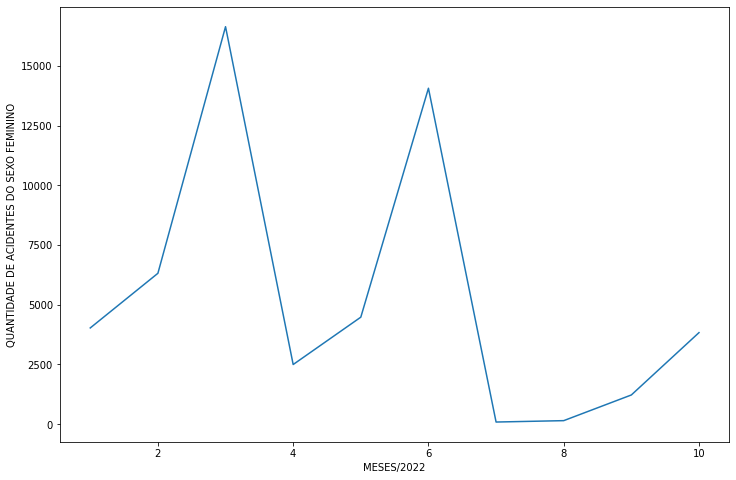

In [ ]:
dfsexo1.groupby([df['data_acidente'].dt.month]).size().plot.line(figsize=(12,8), xlabel='MESES/2022', ylabel='QUANTIDADE DE ACIDENTES DO SEXO FEMININO')

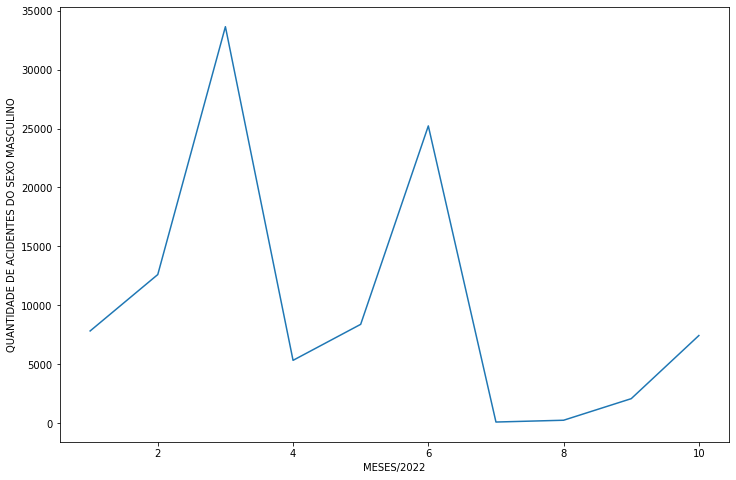

In [ ]:
dfsexo2.groupby([df['data_acidente'].dt.month]).size().plot.line(figsize=(12,8), xlabel='MESES/2022', ylabel='QUANTIDADE DE ACIDENTES DO SEXO MASCULINO')

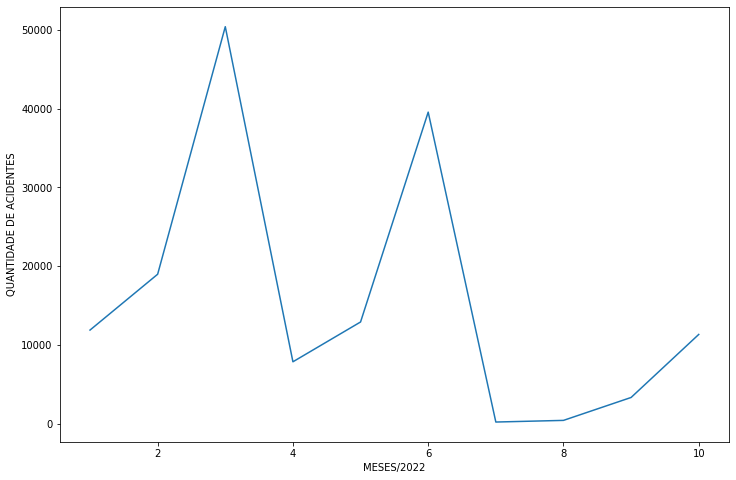

In [ ]:
df.groupby([df['data_acidente'].dt.month]).size().plot.line(figsize=(12,8), xlabel='MESES/2022', ylabel='QUANTIDADE DE ACIDENTES')

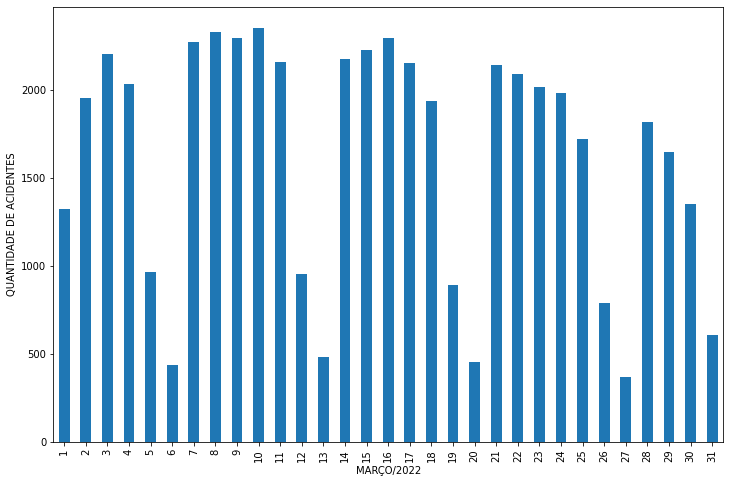

In [ ]:
# dias de março que mais tiveram acidentes
dfmes.groupby([df['data_acidente'].dt.day]).size().plot.bar(figsize=(12,8), xlabel='MARÇO/2022', ylabel='QUANTIDADE DE ACIDENTES')

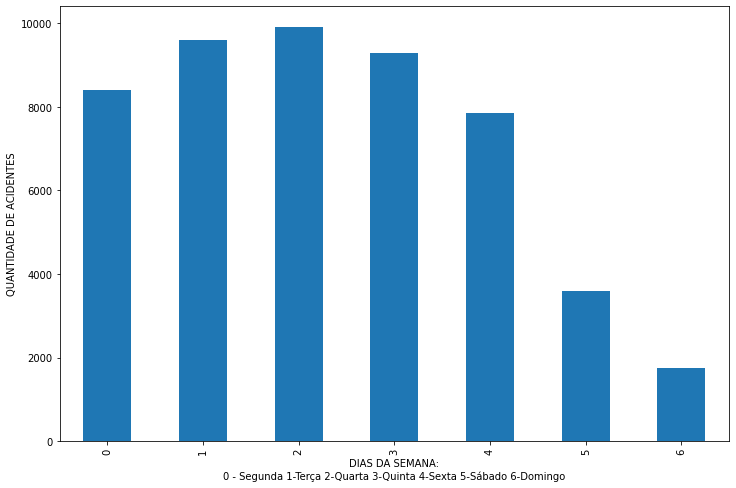

In [ ]:
# dia da semana que mais teve acidentes no mês que mais teve acidentes do ano 
dfmes.groupby([df['data_acidente'].dt.weekday]).size().plot.bar(figsize=(12,8), xlabel='DIAS DA SEMANA:\n0 - Segunda 1-Terça 2-Quarta 3-Quinta 4-Sexta 5-Sábado 6-Domingo', ylabel='QUANTIDADE DE ACIDENTES')

# Análise com PySpark

## Transformando de pandas para *spark*

In [ ]:
esquema = (
    StructType([
        StructField('agente_causador', StringType()),
        StructField('indica_obito_acidente', StringType()),
        StructField('natureza_lesao', StringType()),
        StructField('parte_corpo_atingida', StringType()),
        StructField('cbo', StringType()),
        StructField('cid_10', StringType()),
        StructField('tipo_acidente', StringType()),
        StructField('uf_acidente', StringType()),
        StructField('data_acidente', DateType()),
        StructField('especie_beneficio', StringType()),
        StructField('filiacao_segurado', StringType()),
        StructField('sexo', StringType()),
        StructField('data_nascimento', DateType()),
        StructField('idade', FloatType()),
        StructField('emitente_cat', StringType()),
        StructField('data_emissao_cat', DateType()),
        StructField('dif_dias_acidente_emissao', FloatType()),
        StructField('origem_cadastro', StringType()),
        StructField('cnae_empredagor_codigo', StringType()),
        StructField('cnae_empregador_descricao', StringType()),
        StructField('municipio_empregador', StringType()),
        StructField('uf_empregador', StringType()),
        StructField('cidade_estado_empregador', StringType())
    ])
)

In [ ]:
df = spark.createDataFrame(df, schema = esquema)

## Filtros

In [ ]:
# analisando acidentes que aconteceram no estado de Maranhão
df.filter(F.col('uf_acidente').contains('Maranhão')).show(truncate=False)

+---------------------------------------------+---------------------+-------------------------------------------+---------------------------------------------+---------------------------------------------+--------------------------------------------+-------------+-----------+-------------+-----------------+-----------------+---------+---------------+-----+------------+----------------+-------------------------+---------------+----------------------+---------------------------------------------+---------------------+-------------+-------------------------------+
|agente_causador                              |indica_obito_acidente|natureza_lesao                             |parte_corpo_atingida                         |cbo                                          |cid_10                                      |tipo_acidente|uf_acidente|data_acidente|especie_beneficio|filiacao_segurado|sexo     |data_nascimento|idade|emitente_cat|data_emissao_cat|dif_dias_acidente_emissao|origem_cadastro|cn

In [ ]:
# busca por natureza_lesao que contenham corte usando like
df.filter(F.col('natureza_lesao').like('Corte%')).show(truncate=False)

+---------------------------------------------+---------------------+------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+-------------+-------------+-------------+-----------------+-----------------+---------+---------------+-----+-------------------+----------------+-------------------------+---------------+----------------------+---------------------------------------------+---------------------+-----------------+---------------------------------+
|agente_causador                              |indica_obito_acidente|natureza_lesao                            |parte_corpo_atingida                         |cbo                                          |cid_10                                       |tipo_acidente|uf_acidente  |data_acidente|especie_beneficio|filiacao_segurado|sexo     |data_nascimento|idade|emitente_cat       |data_emissao_cat|dif_dias_acidente_em

In [ ]:
# aplicando um filtro de range de idade dos acidentados entre 40 e 50 anos
df.filter((F.col('idade') < 50) & (F.col('idade') > 40)).show()

+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-----------------+-----------------+---------+---------------+-----+------------+----------------+-------------------------+---------------+----------------------+-------------------------+--------------------+-----------------+------------------------+
|     agente_causador|indica_obito_acidente|      natureza_lesao|parte_corpo_atingida|                 cbo|              cid_10|tipo_acidente|  uf_acidente|data_acidente|especie_beneficio|filiacao_segurado|     sexo|data_nascimento|idade|emitente_cat|data_emissao_cat|dif_dias_acidente_emissao|origem_cadastro|cnae_empredagor_codigo|cnae_empregador_descricao|municipio_empregador|    uf_empregador|cidade_estado_empregador|
+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------

In [ ]:
# analisando os acidentados com maior idade
df.where(F.isnan(F.col("idade")) == False).orderBy(F.col('idade').desc()).show(truncate=False)

+---------------------------------------------+---------------------+-------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+-------------+-------------+-------------+---------------------------------------+-----------------+---------+---------------+-----+-------------+----------------+-------------------------+---------------+----------------------+---------------------------------------------+---------------------+-----------------+-------------------------------+
|agente_causador                              |indica_obito_acidente|natureza_lesao                             |parte_corpo_atingida                         |cbo                                          |cid_10                                       |tipo_acidente|uf_acidente  |data_acidente|especie_beneficio                      |filiacao_segurado|sexo     |data_nascimento|idade|emitente_cat |data_

## SparkSQL

In [ ]:
# olhando as db existentes
spark.sql('show databases').show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [ ]:
# criando database cat
spark.sql('create database CAT').show()

++
||
++
++



In [ ]:
# verificando se foi criada
spark.sql('show databases').show()

+---------+
|namespace|
+---------+
|      cat|
|  default|
+---------+



In [ ]:
# escolhendo o database
spark.sql('use CAT')

DataFrame[]

In [ ]:
# mostrando tabelas existentes
spark.sql('show tables').show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [ ]:
# transformando df em table
df.write.saveAsTable('cat_tratado')

In [ ]:
# verificando se foi criada
spark.sql('show tables').show()

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|      cat|cat_tratado|      false|
+---------+-----------+-----------+



In [ ]:
# mostrando todos os dados da tabela
spark.sql('select * from cat_tratado').show(truncate=False)

+---------------------------------------------+---------------------+-------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+-------------+-------------+-------------+-----------------+-----------------+---------+---------------+-----+------------+----------------+-------------------------+---------------+----------------------+---------------------------------------------+-----------------------+-------------+----------------------------------+
|agente_causador                              |indica_obito_acidente|natureza_lesao                             |parte_corpo_atingida                         |cbo                                          |cid_10                                       |tipo_acidente|uf_acidente  |data_acidente|especie_beneficio|filiacao_segurado|sexo     |data_nascimento|idade|emitente_cat|data_emissao_cat|dif_dias_acidente_emissao|origem_

In [ ]:
# analisando os acidentes nos quais o agente causador foram animais
spark.sql('select * from cat_tratado where agente_causador = "Animal Vivo"').show(truncate=False)

+---------------+---------------------+-------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+-------------+-------------+-------------+-----------------+-----------------+---------+---------------+-----+-------------------+----------------+-------------------------+---------------+----------------------+---------------------------------------------+--------------------------+-------------------+----------------------------------------------+
|agente_causador|indica_obito_acidente|natureza_lesao                             |parte_corpo_atingida                         |cbo                                          |cid_10                                       |tipo_acidente|uf_acidente  |data_acidente|especie_beneficio|filiacao_segurado|sexo     |data_nascimento|idade|emitente_cat       |data_emissao_cat|dif_dias_acidente_emissao|origem_cadastro|cnae_empredagor_

In [ ]:
# principais agentes causadores de acidentes do tipo Doença 
spark.sql('''select agente_causador as agente_causado_doenca, count(agente_causador) as quantidade 
             from cat_tratado
             where tipo_acidente = "Doença" 
             group by agente_causador 
             order by quantidade desc''').show(truncate=False)

+---------------------------------------------+----------+
|agente_causado_doenca                        |quantidade|
+---------------------------------------------+----------+
|Não Informado                                |1678      |
|Agente Infeccioso ou Parasitario - Inclui Bac|1403      |
|Esforco Excessivo, Nic                       |276       |
|Reacao do Corpo a Movimento Voluntario       |213       |
|Ataque de Ser Vivo, Nic                      |179       |
|Agente do Acidente, Nic                      |97        |
|Ser Vivo, Nic                                |71        |
|Rua e Estrada - Superficie Utilizada para Sus|58        |
|Esforco Excessivo ao Manejar, Sacudir ou Arre|55        |
|Inalacao, Ingestao ou Absorcao, Nic          |53        |
|Esforco Excessivo ao Erguer Objeto           |52        |
|Chao - Superficie Utilizada para Sustentar Pe|42        |
|Agente do Acidente Inexistente               |40        |
|Calcada ou Caminho para Pedestre - Superficie|35       

In [ ]:
# quantidade de entradas de acidentes por sexo
spark.sql('select sexo, count(sexo) as quantidade from cat_tratado group by sexo order by quantidade desc').show(truncate=False)

+-------------+----------+
|sexo         |quantidade|
+-------------+----------+
|Masculino    |102917    |
|Feminino     |53328     |
|Não Informado|502       |
|Indeterminado|2         |
+-------------+----------+



In [ ]:
# partes do corpo mais atingidas quando a natureza da lesão é fratura
spark.sql('''select parte_corpo_atingida, count(parte_corpo_atingida) as quantidade 
             from cat_tratado
             where natureza_lesao = "Fratura" 
             group by parte_corpo_atingida 
             order by quantidade desc''').show(100, truncate=False)

+---------------------------------------------+----------+
|parte_corpo_atingida                         |quantidade|
+---------------------------------------------+----------+
|Dedo                                         |5200      |
|Pe (Exceto Artelhos)                         |2746      |
|Perna (Entre O Tornozelo e a Pelvis)         |1449      |
|Braco (Entre O Punho a O Ombro)              |1367      |
|Punho                                        |1079      |
|Mao (Exceto Punho ou Dedos)                  |1025      |
|Perna (Do Tornozelo, Exclusive, ao Joelho, Ex|972       |
|Ombro                                        |958       |
|Antebraco (Entre O Punho e O Cotovelo)       |760       |
|Articulacao do Tornozelo                     |618       |
|Partes Multiplas - Aplica-Se Quando Mais de U|586       |
|Joelho                                       |541       |
|Membros Superiores, Partes Multiplas (Qualque|450       |
|Dorso (Inclusive Musculos Dorsais, Coluna e M|378      

In [ ]:
# natureza de lesão mais frequente quando o tipo do acidente é Trajeto
spark.sql('''select natureza_lesao, count(natureza_lesao) as quantidade 
             from cat_tratado
             where tipo_acidente = "Trajeto" 
             group by natureza_lesao 
             order by quantidade desc''').show(100, truncate=False)

+-------------------------------------------+----------+
|natureza_lesao                             |quantidade|
+-------------------------------------------+----------+
|Fratura                                    |8157      |
|Escoriacao, Abrasao (Ferimento Superficial)|3867      |
|Contusao, Esmagamento (Superficie Cutanea I|2768      |
|Lesao Imediata                             |2490      |
|Distensao, Torcao                          |2005      |
|Luxacao                                    |1999      |
|Outras Lesoes, Nic                         |1325      |
|Lesoes Multiplas                           |1257      |
|Corte, Laceracao, Ferida Contusa, Punctura |1043      |
|Lesao Imediata, Nic                        |584       |
|Concussao Cerebral                         |140       |
|Inflamacao de Articulacao, Tendao ou Muscul|124       |
|Queimadura ou Escaldadura - Efeito de Tempe|47        |
|Amputacao ou Enucleacao                    |44        |
|Doenca, Nic                   

In [ ]:
# os 5 principais agentes causadores de óbitos
spark.sql('''select agente_causador as agente_causado_doenca, count(agente_causador) as quantidade 
             from cat_tratado
             where indica_obito_acidente = "Sim" 
             group by agente_causador 
             order by quantidade desc''').show(5, truncate=False)

+---------------------------------------------+----------+
|agente_causado_doenca                        |quantidade|
+---------------------------------------------+----------+
|Veiculo Rodoviario Motorizado                |125       |
|Impacto de Pes. Contra Objeto em Movimento   |58        |
|Veiculo, Nic                                 |52        |
|Rua e Estrada - Superficie Utilizada para Sus|41        |
|Motocicleta, Motoneta                        |32        |
+---------------------------------------------+----------+
only showing top 5 rows



In [ ]:
# qual o agente causador, a natureza da lesão e o código brasileiro de ocupação do funcionário quando a parte atingida do corpo foi o tórax e houve óbito
spark.sql('''SELECT agente_causador, natureza_lesao, cbo, indica_obito_acidente 
          FROM cat_tratado 
          WHERE indica_obito_acidente = "Sim" AND parte_corpo_atingida  = "Torax (Inclusive Orgaos Internos)"''').show(100, truncate=False)

+---------------------------------------------+-------------------------------------------+---------------------------------------------+---------------------+
|agente_causador                              |natureza_lesao                             |cbo                                          |indica_obito_acidente|
+---------------------------------------------+-------------------------------------------+---------------------------------------------+---------------------+
|Faca, Facao- Ferramenta Manual sem Forca Motr|Corte, Laceracao, Ferida Contusa, Punctura |782410-Motorista de ônibus Urbano            |Sim                  |
|Vidraria, Fibra de Vidro, Lamina, Etc., Excet|Lesao Imediata                             |766125-Montador de Fotolito (Analógico e Digi|Sim                  |
|Impacto de Pes. Contra Objeto em Movimento   |Lesao Imediata                             |782510-Motorista de Caminhão (Rotas Regionais|Sim                  |
|Veiculo Rodoviario Motorizado          

## Window Functions

### Rank

In [ ]:
# cria uma partição do df para utilizar algum tipo de classificação
w0 = Window.partitionBy(F.col('cidade_estado_empregador')).orderBy(F.col('dif_dias_acidente_emissao').asc())

In [ ]:
# ranking do menor tempo entre o acidente e a emissão da cat
df.withColumn('rank', F.rank().over(w0)).select('cidade_estado_empregador', 'dif_dias_acidente_emissao', 'rank').show(truncate=False)

+-------------------------------------+-------------------------+----+
|cidade_estado_empregador             |dif_dias_acidente_emissao|rank|
+-------------------------------------+-------------------------+----+
|Abadia de Goiás-Goiás                |1.0                      |1   |
|Abadia de Goiás-Goiás                |3.0                      |2   |
|Abadia de Goiás-Goiás                |4.0                      |3   |
|Abadia de Goiás-Goiás                |13.0                     |4   |
|Abadia dos Dourados-Rio Grande do Sul|4.0                      |1   |
|Abadiânia-Goiás                      |2.0                      |1   |
|Abadiânia-Goiás                      |7.0                      |2   |
|Abaetetuba-Pará                      |0.0                      |1   |
|Abaetetuba-Pará                      |0.0                      |1   |
|Abaetetuba-Pará                      |0.0                      |1   |
|Abaetetuba-Pará                      |0.0                      |1   |
|Abaet

In [ ]:
# row_number retornando o número da linha de acordo com dif_dias_acidente_emissao
df.withColumn('numero_linha', F.row_number().over(w0)).select('cidade_estado_empregador', 'dif_dias_acidente_emissao', 'numero_linha').show(truncate=False)

+-------------------------------------+-------------------------+------------+
|cidade_estado_empregador             |dif_dias_acidente_emissao|numero_linha|
+-------------------------------------+-------------------------+------------+
|Abadia de Goiás-Goiás                |1.0                      |1           |
|Abadia de Goiás-Goiás                |3.0                      |2           |
|Abadia de Goiás-Goiás                |4.0                      |3           |
|Abadia de Goiás-Goiás                |13.0                     |4           |
|Abadia dos Dourados-Rio Grande do Sul|4.0                      |1           |
|Abadiânia-Goiás                      |2.0                      |1           |
|Abadiânia-Goiás                      |7.0                      |2           |
|Abaetetuba-Pará                      |0.0                      |1           |
|Abaetetuba-Pará                      |0.0                      |2           |
|Abaetetuba-Pará                      |0.0          

# Salvando Dados Tratados

In [ ]:
df_pd = df.toPandas()

In [ ]:
# fazendo o load para enviar o arquivo ao gcs
df_pd.to_csv('CAT_tratado.csv',index=False)

## MongoDB Atlas

In [ ]:
df_pd.dtypes

agente_causador               object
indica_obito_acidente         object
natureza_lesao                object
parte_corpo_atingida          object
cbo                           object
cid_10                        object
tipo_acidente                 object
uf_acidente                   object
data_acidente                 object
especie_beneficio             object
filiacao_segurado             object
sexo                          object
data_nascimento               object
idade                        float32
emitente_cat                  object
data_emissao_cat              object
dif_dias_acidente_emissao    float32
origem_cadastro               object
cnae_empredagor_codigo        object
cnae_empregador_descricao     object
municipio_empregador          object
uf_empregador                 object
cidade_estado_empregador      object
dtype: object

In [ ]:
# alterado os tipos das colunas para os tipos certos (não irei mudar a dia_hoje, pois droparei essa coluna por não fazer importancia na nossa analise)
df_pd["data_acidente"] = pd.to_datetime(df_pd["data_acidente"], errors="coerce")
df_pd["data_acidente"] = df_pd["data_acidente"].astype(object).where(df_pd["data_acidente"].notnull(), None)

In [ ]:
df_pd["data_nascimento"] = pd.to_datetime(df_pd["data_nascimento"], errors="coerce")
df_pd["data_nascimento"] = df_pd["data_nascimento"].astype(object).where(df_pd["data_nascimento"].notnull(), None)

In [ ]:
df_pd["data_emissao_cat"] = pd.to_datetime(df_pd["data_emissao_cat"], errors="coerce")
df_pd["data_emissao_cat"] = df_pd["data_emissao_cat"].astype(object).where(df_pd["data_emissao_cat"].notnull(), None)

In [ ]:
df_pd.dtypes

agente_causador               object
indica_obito_acidente         object
natureza_lesao                object
parte_corpo_atingida          object
cbo                           object
cid_10                        object
tipo_acidente                 object
uf_acidente                   object
data_acidente                 object
especie_beneficio             object
filiacao_segurado             object
sexo                          object
data_nascimento               object
idade                        float32
emitente_cat                  object
data_emissao_cat              object
dif_dias_acidente_emissao    float32
origem_cadastro               object
cnae_empredagor_codigo        object
cnae_empregador_descricao     object
municipio_empregador          object
uf_empregador                 object
cidade_estado_empregador      object
dtype: object

In [ ]:
# conector do mongo atlas
uri = "mongodb+srv://giovana-soulcode.quvpom8.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri, tls=True, tlsCertificateKeyFile='/content/drive/MyDrive/X509-cert-7346878477947766211.pem')

In [ ]:
# escolha/crie o database e colecao
db = client['CAT']
colecao = db['CAT_tratado']
# verificar conexão / Qtd. documentos da coleção
colecao.count_documents({})

0

In [ ]:
df_pd.shape

(156749, 23)

In [ ]:
# decidimos dividir o dataset em datasets menores para evitar erros
df_pd_parte1 = df_pd.loc[0:40000]
df_pd_parte2 = df_pd.loc[40001:80000]
df_pd_parte3 = df_pd.loc[80001:120000]
df_pd_parte4 = df_pd.loc[120001:156749]

In [ ]:
# enviar o DF para colecao selecionada no mongo
df_pd_dict1 = df_pd_parte1.to_dict("records")
colecao.insert_many(df_pd_dict1)

In [ ]:
# enviar o DF para colecao selecionada no mongo
df_pd_dict2 = df_pd_parte2.to_dict("records")
colecao.insert_many(df_pd_dict2)

In [ ]:
# enviar o DF para colecao selecionada no mongo
df_pd_dict3 = df_pd_parte3.to_dict("records")
colecao.insert_many(df_pd_dict3)

In [ ]:
# enviar o DF para colecao selecionada no mongo
df_pd_dict4 = df_pd_parte4.to_dict("records")
colecao.insert_many(df_pd_dict4)

In [ ]:
colecao.count_documents({})

156749

In [ ]:
# verificando se ocorreu tudo bem utilizando pandas
cursor = colecao.find({})
df_pd1 = pd.DataFrame(list(cursor))
df_pd1

,_id,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
0,639dd8aaf631ef4c962d8d1a,Não Informado,Não,Doenca Contagiosa ou Infecciosa (Tuberculos,"Sistemas e Aparelhos, Nic",322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,Doença,Paraíba,2022-01-21,Pa,Empregado,Masculino,1993-10-03,29.0,Empregador,2022-03-01,39.0,Internet,8610,Atividades de Atendimento Hospitalar,Macapá,Amapá,Macapá-Amapá
1,639dd8aaf631ef4c962d8d1b,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",Não,Fratura,Dedo,782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,Típico,Maranhão,2022-02-28,Pa,Empregado,Masculino,1978-04-29,45.0,Empregador,2022-03-01,1.0,Internet,4754,"Comercio Varejista Especializado de Moveis, C",Sorocaba,São Paulo,Sorocaba-São Paulo
2,639dd8aaf631ef4c962d8d1c,Reacao do Corpo a Movimento Voluntario,Não,"Outras Lesoes, Nic","Tronco, Nic",723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,Típico,Maranhão,2022-02-04,Pa,Empregado,Masculino,1977-10-10,45.0,Empregador,2022-03-01,25.0,Internet,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Araraquara,São Paulo,Araraquara-São Paulo
3,639dd8aaf631ef4c962d8d1d,Veiculo Rodoviario Motorizado,Não,Fratura,Mao (Exceto Punho ou Dedos),782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,Típico,Maranhão,2022-02-22,Pa,Empregado,Masculino,1963-07-31,59.0,Empregador,2022-03-02,8.0,Internet,4930,Transporte Rodoviario de Carga,Cabreúva,São Paulo,Cabreúva-São Paulo
4,639dd8aaf631ef4c962d8d1e,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),513435-Atendente Lanchonete,Não Informado,Trajeto,Roraima,2022-02-27,Pa,Empregado,Masculino,2000-06-09,23.0,Empregador,2022-03-02,3.0,Internet,5611,Restaurantes e Outros Estabelecimentos de Ser,Maringá,Paraná,Maringá-Paraná
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156744,639dd8e4f631ef4c962ff162,"Motocicleta, Motoneta",Não,"Outras Lesoes, Nic","Dorso (Inclusive Musculos Dorsais, Coluna e M",510310-Superv. Vigilantes,M54.9 Dorsalgia Ne,Trajeto,Não Informado,2022-10-05,Pa,Empregado,Masculino,1996-06-13,27.0,Empregador,2022-10-06,1.0,Internet,8111,"Servicos Combinados para Apoio a Edificios, E",Porto Alegre,Rio Grande do Sul,Porto Alegre-Rio Grande do Sul
156745,639dd8e4f631ef4c962ff163,"Veiculo, Nic",Não,Lesao Imediata,"Membros Inferiores, Partes Multiplas (Qualque",212420-Analista de Suporte Computacional,V29.9 Motociclista Acid Trans Ne,Trajeto,Tocantins,2022-09-30,Pa,Empregado,Masculino,1984-04-28,39.0,Empregador,2022-10-06,6.0,Internet,6421,Bancos Comerciais,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro-Rio de Janeiro
156746,639dd8e4f631ef4c962ff164,Impacto de Pes. Contra Objeto em Movimento,Não,Lesao Imediata,Dedo,322205-Tec. de Enfermagem,Y28.2 Escolas Outr Instit Areas Admin Publica,Típico,Não Informado,2022-09-30,Pa,Empregado,Feminino,1974-07-27,48.0,Empregador,2022-10-06,6.0,Internet,9430,Atividades de Associacoes de Defesa de Direit,São Luís,Maranhão,São Luís-Maranhão
156747,639dd8e4f631ef4c962ff165,"Metal - Inclui Liga Ferrosa e nao Ferrosa, Tu",Não,"Escoriacao, Abrasao (Ferimento Superficial)",Olho (Inclusive Nervo Otico e Visao),992115-Borracheiro,H57.8 Outr Transt Espec do Olho e Anexos,Típico,Não Informado,2022-09-23,Pa,Empregado,Masculino,1993-11-17,29.0,Empregador,2022-10-06,13.0,Internet,4530,Comercio de Pecas e Acessorios para Veiculos,Farroupilha,Rio Grande do Sul,Farroupilha-Rio Grande do Sul


## GCS

In [ ]:
# # função para fazer upload de arquivo no bucket
def upload_blob(bucket, arquivo, destino):
    client = storage.Client()
    bucket = client.bucket(bucket)
    blob = bucket.blob(destino)

    blob.upload_from_filename(arquivo)

    print(
        f"Arquivo {arquivo} upado em {destino}."
    )

In [ ]:
# # Upload do arquivo 
bucket = 'bc26-projeto-aquecimento'
arquivo = '/content/CAT_tratado.csv'
destino = 'tratado/CAT_tratado.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/CAT_tratado.csv upado em tratado/CAT_tratado.csv.


In [ ]:
# caregando dfs pelo pandas
df1 = pd.read_csv('gs://bc26-projeto-aquecimento/tratado/CAT_tratado.csv', sep=',')

In [ ]:
df1.head(5)

,agente_causador,indica_obito_acidente,natureza_lesao,parte_corpo_atingida,cbo,cid_10,tipo_acidente,uf_acidente,data_acidente,especie_beneficio,filiacao_segurado,sexo,data_nascimento,idade,emitente_cat,data_emissao_cat,dif_dias_acidente_emissao,origem_cadastro,cnae_empredagor_codigo,cnae_empregador_descricao,municipio_empregador,uf_empregador,cidade_estado_empregador
0,Não Informado,Não,Doenca Contagiosa ou Infecciosa (Tuberculos,"Sistemas e Aparelhos, Nic",322205-Tec. de Enfermagem,B34.2 Infecc p/Coronavirus Ne,Doença,Paraíba,2022-01-21,Pa,Empregado,Masculino,1993-10-03,29.0,Empregador,2022-03-01,39.0,Internet,8610,Atividades de Atendimento Hospitalar,Macapá,Amapá,Macapá-Amapá
1,"Madeira (Toro, Madeira Serrada, Pranchao, Pos",Não,Fratura,Dedo,782310-Motorista de Furgão ou Veículo Similar,S62.6 Frat de Outr Dedos,Típico,Maranhão,2022-02-28,Pa,Empregado,Masculino,1978-04-29,45.0,Empregador,2022-03-01,1.0,Internet,4754,"Comercio Varejista Especializado de Moveis, C",Sorocaba,São Paulo,Sorocaba-São Paulo
2,Reacao do Corpo a Movimento Voluntario,Não,"Outras Lesoes, Nic","Tronco, Nic",723320-Pintor Veículos (Fabricação),M54.5 Dor Lombar Baixa,Típico,Maranhão,2022-02-04,Pa,Empregado,Masculino,1977-10-10,45.0,Empregador,2022-03-01,25.0,Internet,2930,"Fabricacao de Cabines, Carrocerias e Reboques",Araraquara,São Paulo,Araraquara-São Paulo
3,Veiculo Rodoviario Motorizado,Não,Fratura,Mao (Exceto Punho ou Dedos),782510-Motorista de Caminhão (Rotas Regionais,S62.3 Frat de Outr Ossos do Metacarpo,Típico,Maranhão,2022-02-22,Pa,Empregado,Masculino,1963-07-31,59.0,Empregador,2022-03-02,8.0,Internet,4930,Transporte Rodoviario de Carga,Cabreúva,São Paulo,Cabreúva-São Paulo
4,Rua e Estrada - Superficie Utilizada para Sus,Não,Fratura,Antebraco (Entre O Punho e O Cotovelo),513435-Atendente Lanchonete,Não Informado,Trajeto,Roraima,2022-02-27,Pa,Empregado,Masculino,2000-06-09,23.0,Empregador,2022-03-02,3.0,Internet,5611,Restaurantes e Outros Estabelecimentos de Ser,Maringá,Paraná,Maringá-Paraná


## MySQL

In [ ]:
# transformando pro pandas
df_sql = df.toPandas()

### Conectando

In [ ]:
# função para conectar ao banco
def conexao_db(servidor, usuario, senha, nome_do_banco):
  conexao = None
  try:
    conexao = mysql.connector.connect(host=servidor, user=usuario, passwd=senha, database=nome_do_banco)
    print(f'Conexão ao banco {nome_do_banco} efetuada com sucesso!')
  except:
    print(f'Erro ao conectar ao banco {nome_do_banco}!')
  
  return conexao

In [ ]:
# criando conexão
con = conexao_db('104.196.125.166', 'root', 'root', 'cat')

Conexão ao banco cat efetuada com sucesso!


### Executar SQL (INSERT, DELETE, UPDATE)

In [ ]:
# Você pode criar uma tabela de banco de dados no MySQL e inserir esses dados usando a função to_sql() no Pandas. 
# A função to_sql() requer dois parâmetros obrigatórios - nome da tabela e um objeto do mecanismo SQLAlchemy.
# SQLAlchemy é um kit de ferramentas Python e Object Relational Mapper (ORM) que permite que Python trabalhe com bancos de dados SQL.
# um engine é a base de qualquer aplicativo SQLAlchemy que se comunica com o banco de dados.
# O engine object é criado chamando a função create_engine() com a linguagem do banco de dados e os parâmetros de conexão.

# dados de para realizar conexão com o servidor
servidor = '104.196.125.166'
nome_do_banco = 'cat'
usuario = 'root'
senha = 'root'

# ciar uma SQLAlchemy engine para conectar com o MySQL 
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=servidor, db=nome_do_banco, user=usuario, pw=senha))

# convertendo dataframe em uma table do sql                                   
df_sql.to_sql('cat_tratado', engine, index=True, index_label="id")

In [ ]:
#executando engine para alterar tabela
engine.execute('ALTER TABLE cat_tratado ADD PRIMARY KEY (id);')

In [ ]:
#criando função para fazer query
def executar_query(conexao, sql):
  cursor = conexao.cursor()
  try:
    cursor.execute(sql)
    conexao.commit()
    print('Query executada com sucesso!')
  except:
    print('Não foi possível executar a query!')

In [ ]:
# fazendo uma query para alterar table
sql = 'ALTER TABLE cat_tratado MODIFY COLUMN data_emissao_cat DATE'
executar_query(con, sql)

Query executada com sucesso!


In [ ]:
sql = 'ALTER TABLE cat_tratado MODIFY COLUMN data_acidente DATE'
executar_query(con, sql)

Query executada com sucesso!


In [ ]:
sql = 'ALTER TABLE cat_tratado MODIFY COLUMN data_nascimento DATE'
executar_query(con, sql)

Query executada com sucesso!


### Read

In [ ]:
# definindo função para fazer leituras no banco de dados
def leitura_de_tabelas(conexao, sql):
  cursor = conexao.cursor()
  retorno = None
  try:
    cursor.execute(sql)
    retorno = cursor.fetchall()
    return retorno
  except:
    print('Erro ao listar os dados da tabela no banco!')

In [ ]:
# realizando leituras
sql = 'SHOW TABLES'
cat = leitura_de_tabelas(con, sql)

for x in cat:
  print(x)

('cat_tratado',)


In [ ]:
sql = 'SELECT * FROM cat_tratado LIMIT 10'
cat = leitura_de_tabelas(con, sql)

for x in cat:
  print(x)

(0, 'Não Informado', 'Não', 'Doenca Contagiosa ou Infecciosa (Tuberculos', 'Sistemas e Aparelhos, Nic', '322205-Tec. de Enfermagem', 'B34.2 Infecc p/Coronavirus Ne', 'Doença', 'Paraíba', datetime.date(2022, 1, 21), 'Pa', 'Empregado', 'Masculino', datetime.date(1993, 10, 3), 29.0, 'Empregador', datetime.date(2022, 3, 1), 39.0, 'Internet', '8610', 'Atividades de Atendimento Hospitalar', 'Macapá', 'Amapá', 'Macapá-Amapá')
(1, 'Madeira (Toro, Madeira Serrada, Pranchao, Pos', 'Não', 'Fratura', 'Dedo', '782310-Motorista de Furgão ou Veículo Similar', 'S62.6 Frat de Outr Dedos', 'Típico', 'Maranhão', datetime.date(2022, 2, 28), 'Pa', 'Empregado', 'Masculino', datetime.date(1978, 4, 29), 45.0, 'Empregador', datetime.date(2022, 3, 1), 1.0, 'Internet', '4754', 'Comercio Varejista Especializado de Moveis, C', 'Sorocaba', 'São Paulo', 'Sorocaba-São Paulo')
(2, 'Reacao do Corpo a Movimento Voluntario', 'Não', 'Outras Lesoes, Nic', 'Tronco, Nic', '723320-Pintor Veículos (Fabricação)', 'M54.5 Dor Lom

In [ ]:
con.close()

# DASHBOARD LOOKER

Novos insights disponíveis [aqui](https://datastudio.google.com/reporting/355ba5ff-f9c3-4efb-925e-0a4a5d330384).